# Imports

In [9]:
import numpy as np
import pandas as pd
import re
import os

import operator

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stops = stopwords.words('english')

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Cargar data

In [10]:
data = pd.read_csv('../input/clean-nlp-desasters/clean_train.csv')
test = pd.read_csv('../input/clean-nlp-desasters/clean_test.csv')

# Se procede a analizar el corpus de texto con el que se cuenta para:
    
**Extraer features utiles para darle a nuestros XGBoosts**
    
**Allanarle el camino a nuestras redes neuronales en su etapa de embbeding (en particular para BERT y T5)**
    
BERT y T5 son modelos preentrenados con una enormidad de texto muy limpio. Si le damos data sucia va a tener que reaprender un monton de palabras "nuevas" y eso va a menguar su performance de forma innecesaria ya que muchas palabras que estas redes van a considerar como nuevas o distintas son realmente la misma sea en significado o en escritura (salvo typos)

# Hipotesis


Todo lo que se va a hacer ahora es sobre el set de train SOLAMENTE porque sino estariamos haciendo las cosas mal. 

Lo que limpiamos debe basarse solo en lo que va a ver el modelo y no en consideraciones del set de test o de lo contrario no vamos a poder medir bien el overfit.

De todas formas todo lo que se hace aca (analizando el set de train) asume que puede generalizarse al set de test. Es decir, asumimos que las distribuciones encontradas sobre el set de train son las mismas sobre el set de test.

In [11]:
#Analizamos todo el corpus de texto del dataset

data = data.fillna('') #No nos molesta reemplazar los campos nulos por strings vacios
data['complete_text'] = data.location + ' ' + data.keyword + ' ' + data.text

corpus = ' '.join((data.complete_text).to_list())
corpus

"    Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all     Forest fire near La Ronge Sask. Canada     All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected     13,000 people receive #wildfires evacuation orders in California      Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school      #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires     #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas     I'm on top of the hill and I can see a fire in the woods...     There's an emergency evacuation happening now in the building across the street     I'm afraid that the tornado is coming to our area...     Three people died from the heat wave so far     Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GON

# Hashtags

In [12]:
hashtag_pattern = re.compile('#\S*')
hashtags = pd.Series(re.findall(hashtag_pattern,corpus))
hashtags

0       #earthquake
1        #wildfires
2           #Alaska
3        #wildfires
4        #RockyFire
           ...     
3436        #iPhone
3437      #breaking
3438            #LA
3439     #WorldNews
3440    #stormchase
Length: 3441, dtype: object

In [13]:
print("Canitdad de hashtags en el corpus: ",len(hashtags))
print("Canitdad de hashtags unicos en el corpus: ",len(set(hashtags)))
counts = hashtags.value_counts()

Canitdad de hashtags en el corpus:  3441
Canitdad de hashtags unicos en el corpus:  2179


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


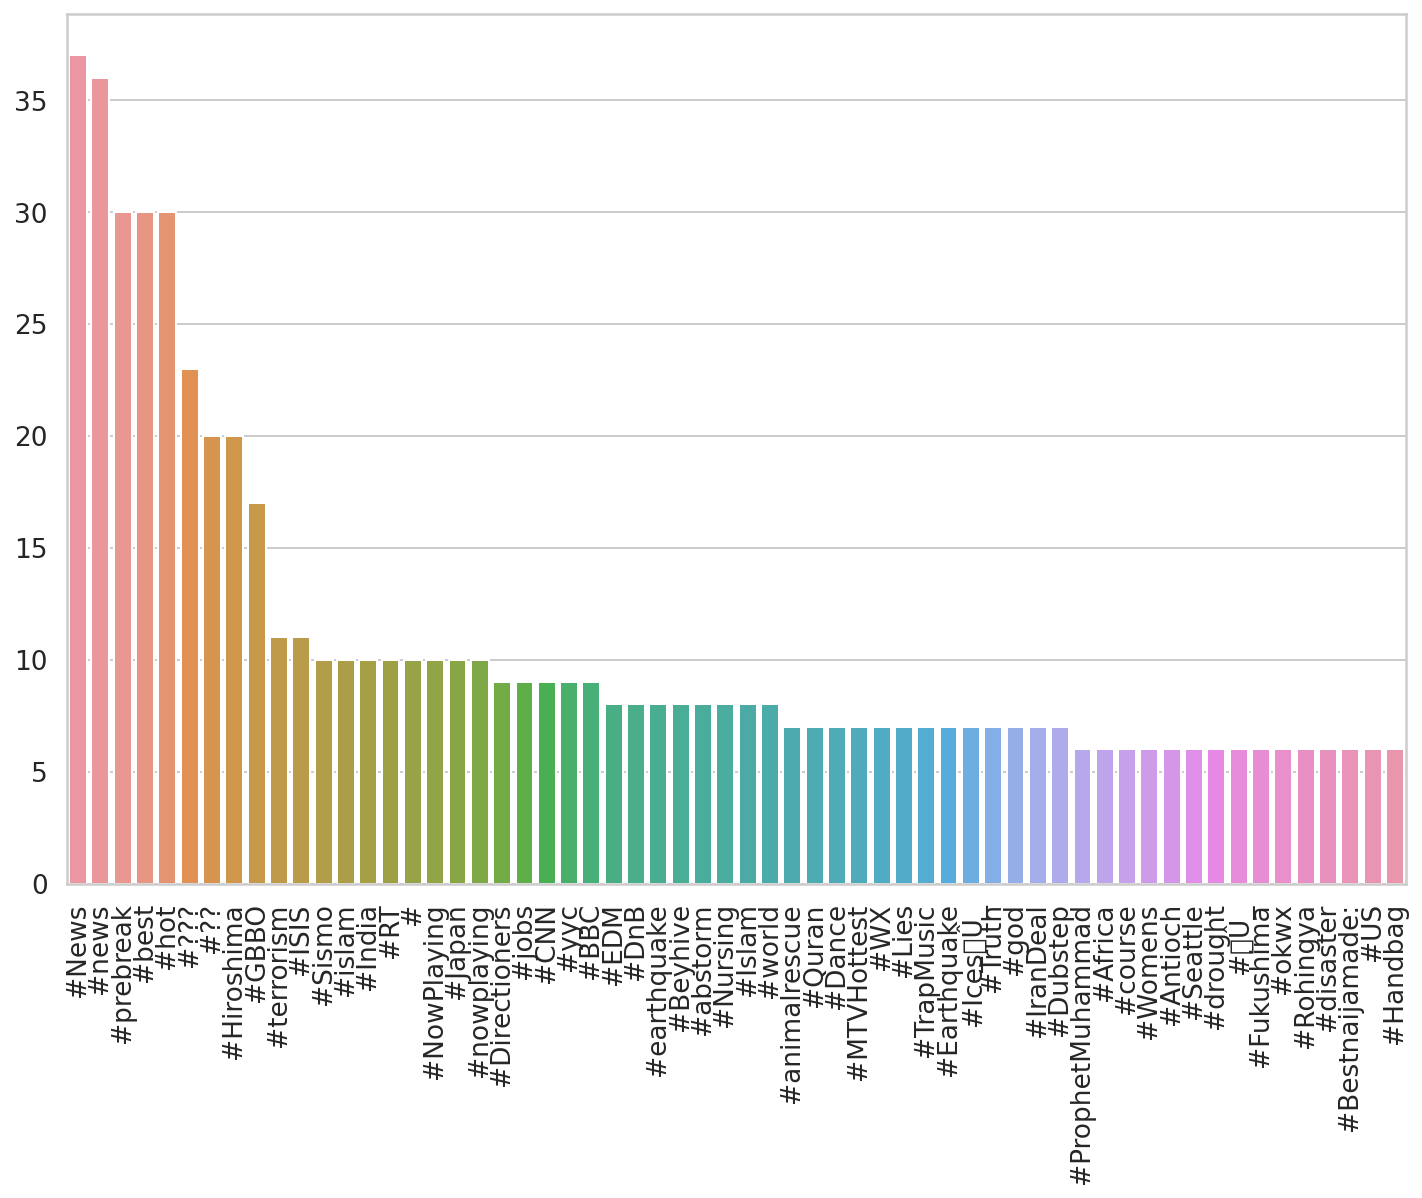

In [14]:
amount = 60
ax = sns.barplot(x = counts.head(amount).index, y = counts.head(amount).values)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Cantidad de hashtags con tanta frecuencia

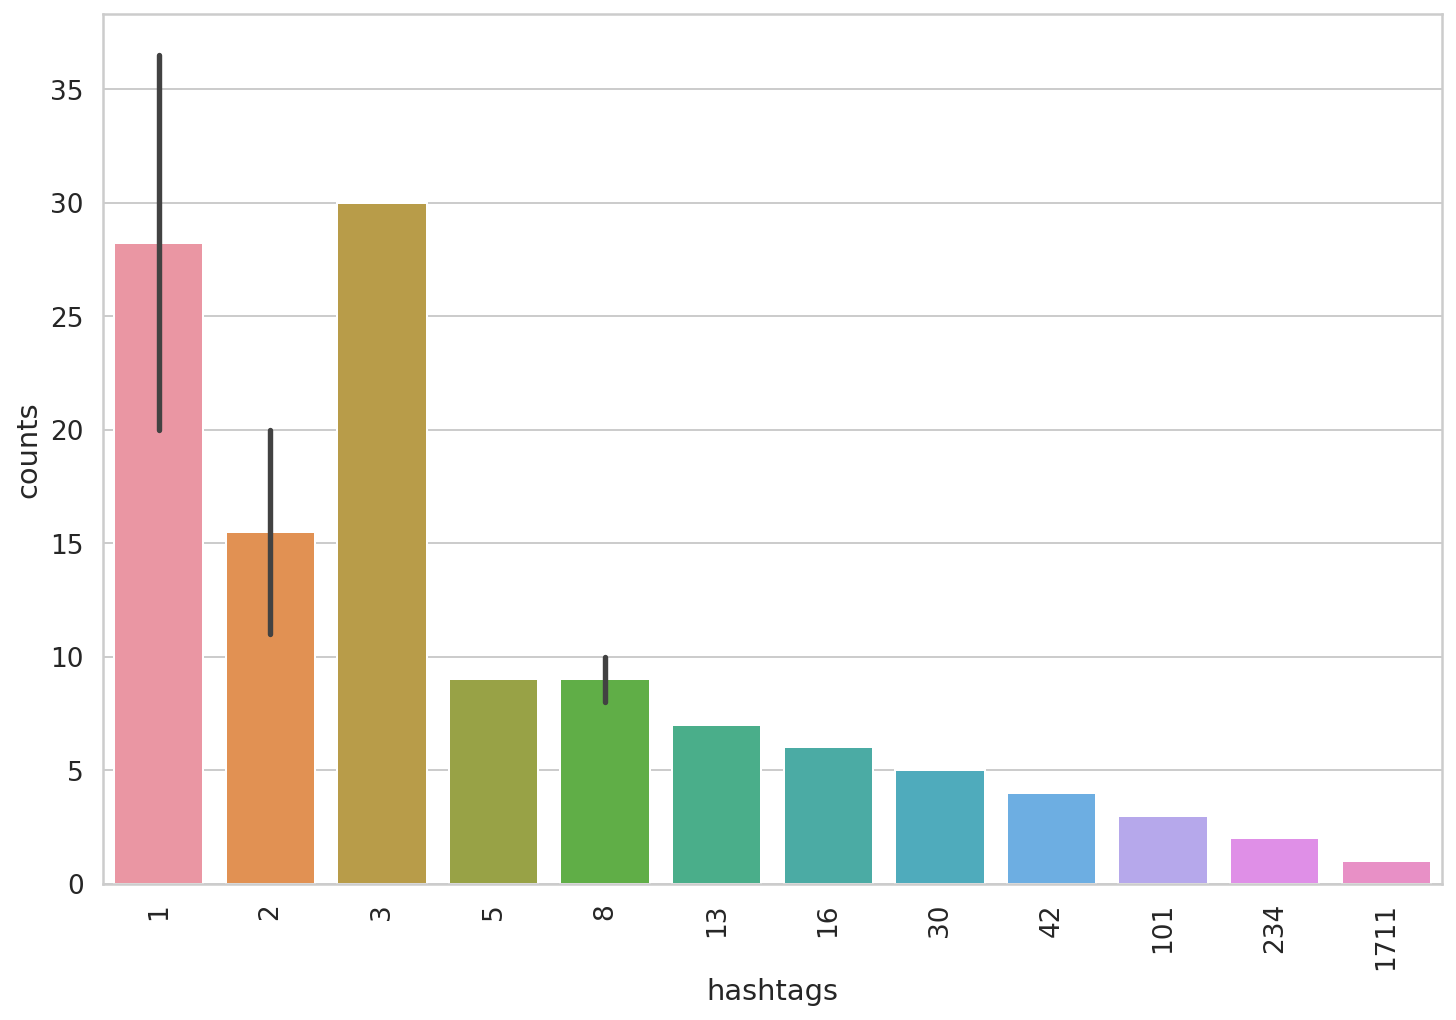

In [15]:
counts = hashtags.value_counts().to_frame().reset_index()
counts.columns = ['hashtags','counts']
counts_of_counts = counts.groupby('counts').count().reset_index()

ax = sns.barplot(x = counts_of_counts.hashtags, y = counts_of_counts.counts)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Peso de cada clase de hashtags

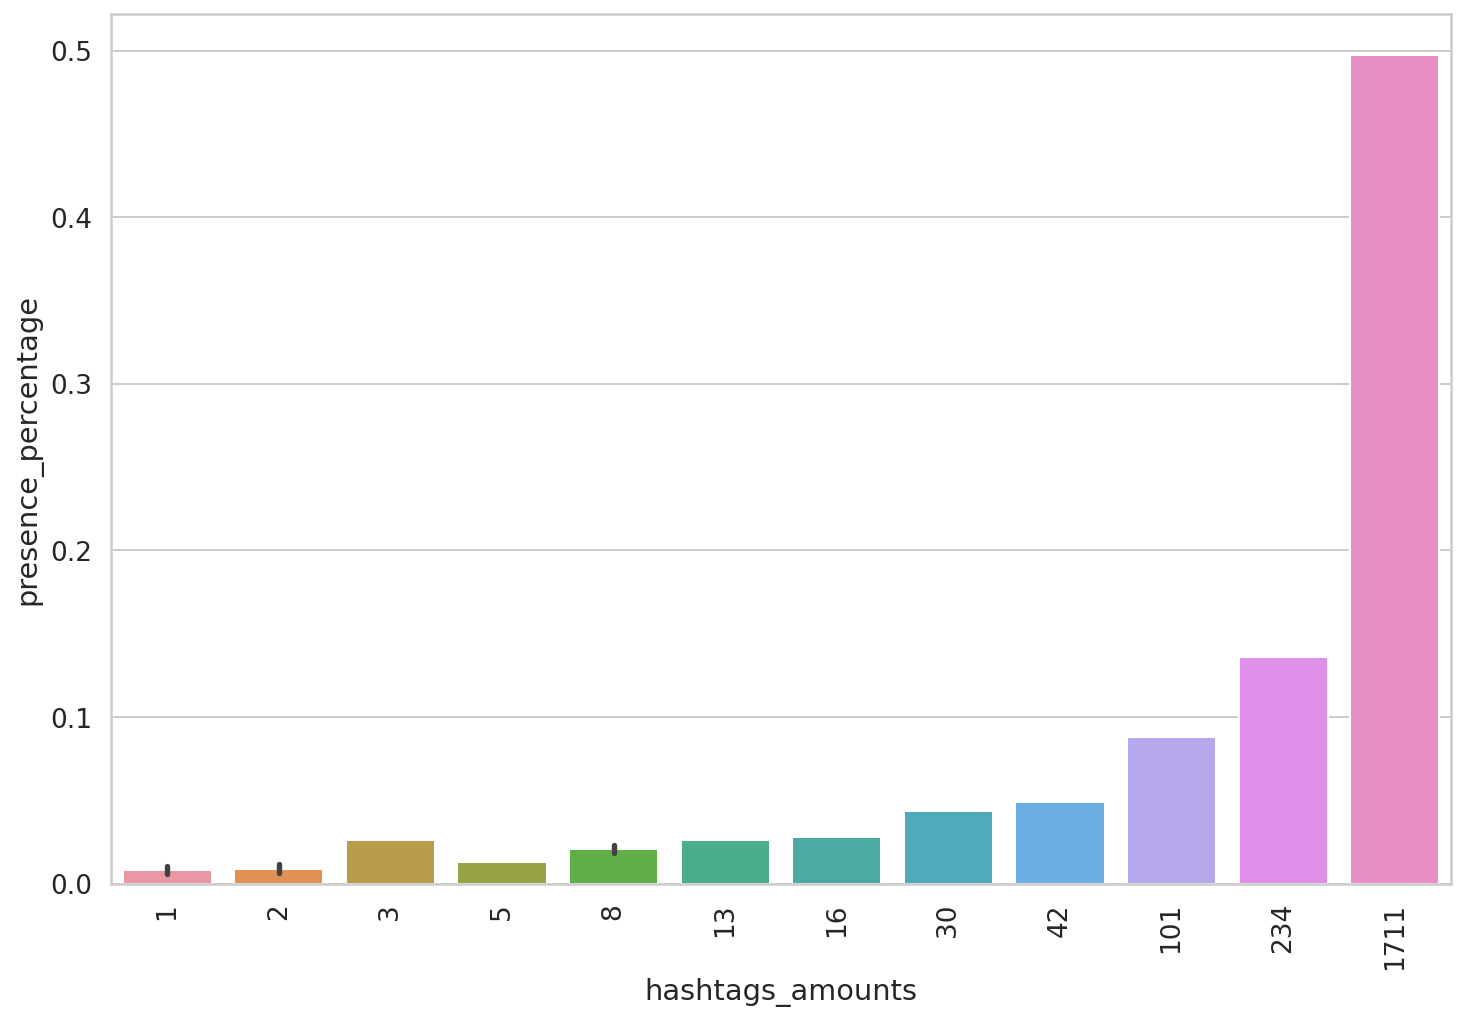

In [16]:
total_hashtags = len(hashtags)

counts_of_counts['presence_percentage'] = counts_of_counts.counts * counts_of_counts.hashtags / total_hashtags
counts_of_counts.columns = ['counts','hashtags_amounts','presence_percentage']

ax = sns.barplot(x = counts_of_counts.hashtags_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Vemos que algunos hashtags se usan bastante y quizas tengan importancia para predecir el label por lo que queremos quedarnoslos y hacer que nuestro modelo los aprenda.

Sin embargo hemos visto que son muchisimos y no tenemos tantos tweets como para que el modelo pudiese aprenderlos todos. Ademas, segun vemos en el grafico anterior, las clases de tweets agrupadas por probabilidad de ocurrencia siguen una power law. Esto quiere decir que la mayoria tienen poca precencia u ocurrencia, mientras que unos pocos son los que mas se usan.

Vamos a buscar a partir de que threshold de agrupamiento de tweets el porcentage de los desechados es menor a 50%

In [17]:
counts_of_counts = counts_of_counts.sort_values('counts', ascending = False).reset_index()
counts_of_counts.head()

index  counts  hashtags_amounts  presence_percentage
0     16      37                 1             0.010753
1     15      36                 1             0.010462
2     14      30                 3             0.026155
3     13      23                 1             0.006684
4     12      20                 2             0.011625

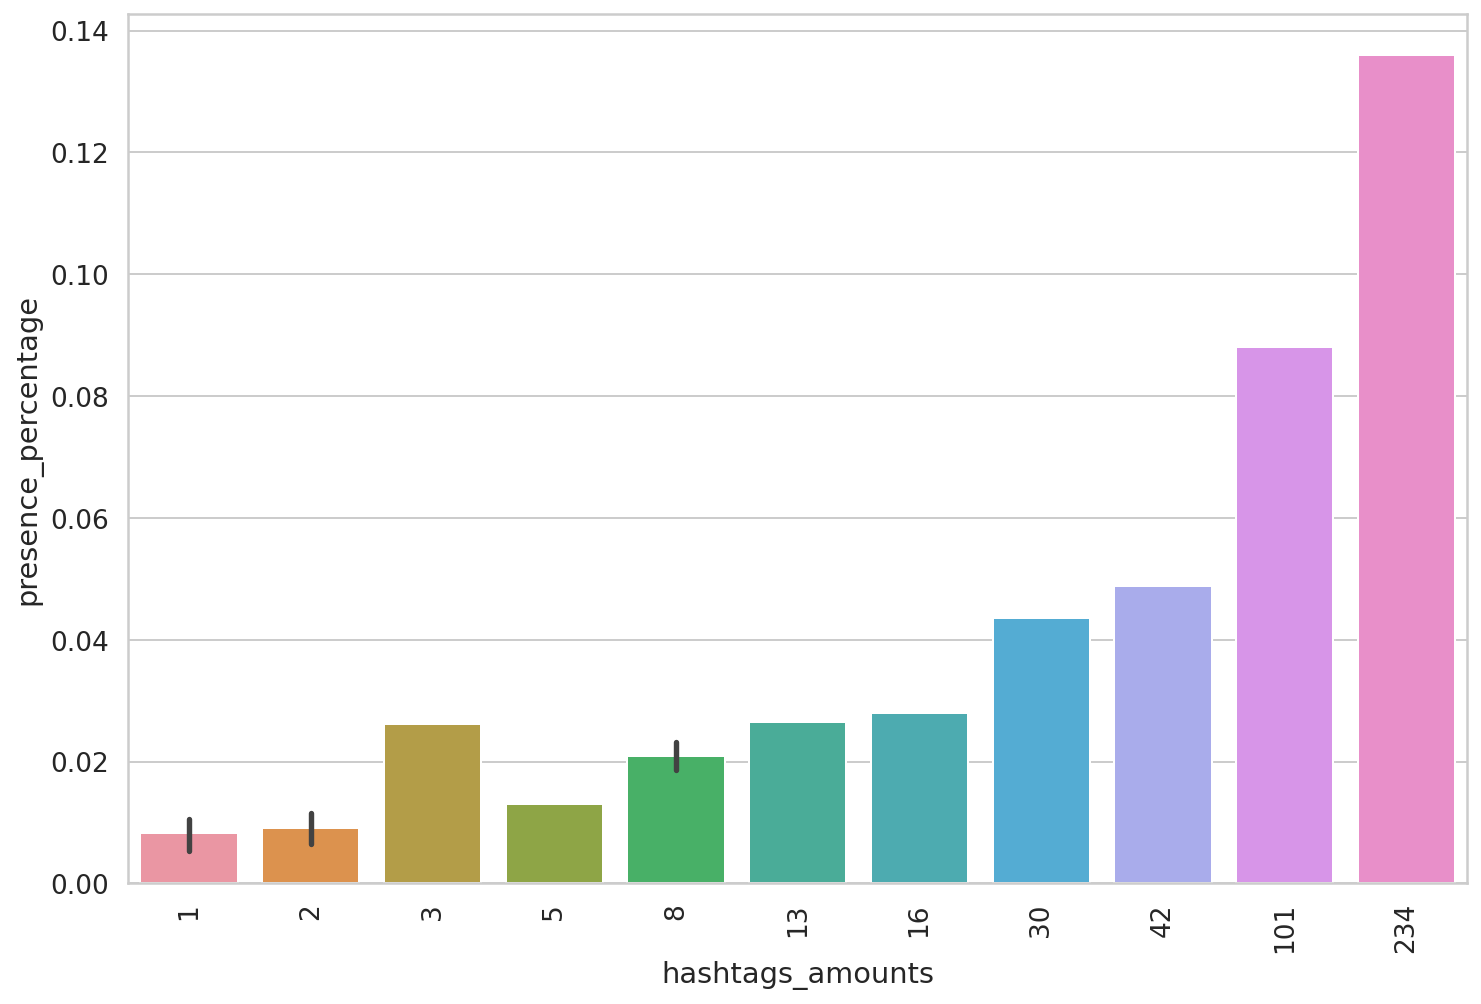

In [18]:
class_idx = 0
cumulated_prescence = 0
for idx,hashtag_class in counts_of_counts.iterrows():
    cumulated_prescence += hashtag_class.presence_percentage
    if cumulated_prescence >= 0.5:
        class_idx = idx
        break


to_filter_counts_of_counts = counts_of_counts.iloc[class_idx + 1:]
counts_of_counts = counts_of_counts.iloc[:class_idx + 1]
        
ax = sns.barplot(x = counts_of_counts.hashtags_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [19]:
print("Cantidad de hashtags que quedan: ",counts_of_counts.presence_percentage.sum() * total_hashtags)
print("Cantidad de hashtags que que habia: ",total_hashtags)
print(f"Porcentaje filtrado por baja ocurrencia: {round(1 - counts_of_counts.presence_percentage.sum(),3)*100}%")

Cantidad de hashtags que quedan:  1730.0
Cantidad de hashtags que que habia:  3441
Porcentaje filtrado por baja ocurrencia: 49.7%


Ahora que seleccionamos que hashtags filtrar vamos a proceder a crear la funcion que filtra del dataset aquellos hashtags que seleccionamos para filtrar.

En nuestro caso filtrar simplemente significa asignarle el tag HASHTAG. De este modo el 49.7% de las ocurrencias de hashtags tendran ese tag y el modelo que usemos sera mas capaz de aprender de estos.

In [20]:
HASHTAG = ' HASHTAG '

to_filter_hashtags = counts.merge(
        to_filter_counts_of_counts, on='counts'
).hashtags.values

cleanHashtags = lambda x: HASHTAG if x.group(0) in to_filter_hashtags else ' ' + x.group(0)

# Menciones

La operatoria sera analoga a la de los hashtags asi que se procedera a hacerlo de forma menos explicita

In [21]:
mentions_pattern = re.compile('@\S*(?!\.com)')
mentions = pd.Series(re.findall(mentions_pattern,corpus))

In [22]:
mentions

0                @bbcmtd
1            @PhDSquares
2        @southridgelife
3       @Alexis_Sanchez:
4                   @Û_
              ...       
2779      @cameronhacker
2780         @engineshed
2781      @LivingSafely:
2782        @aria_ahrary
2783        @TheTawniest
Length: 2784, dtype: object

In [23]:
print("Canitdad de menciones en el corpus: ",len(mentions))
print("Canitdad de menciones unicos en el corpus: ",len(set(mentions)))
counts = mentions.value_counts()
counts

Canitdad de menciones en el corpus:  2784
Canitdad de menciones unicos en el corpus:  2365


@YouTube         82
@                34
@ArianaGrande    11
@Change           9
@POTUS            9
                 ..
@kwislo           1
@burberryant      1
@DatTomm          1
@TayIorrMade      1
@RogueWatson      1
Length: 2365, dtype: int64

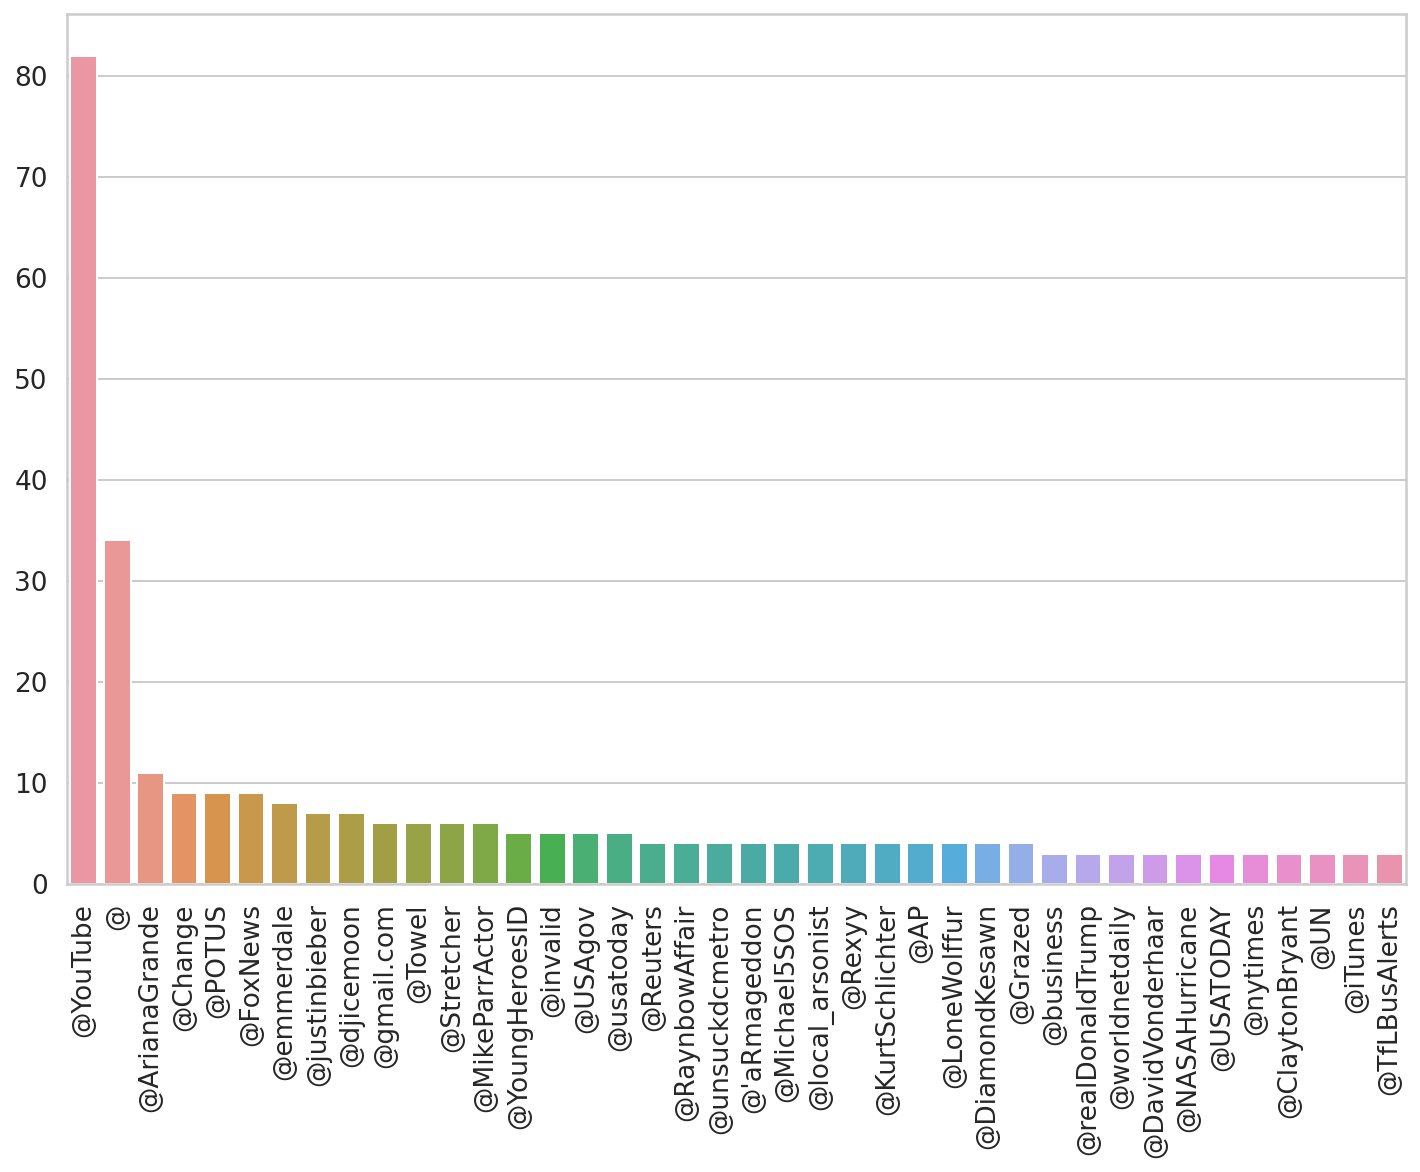

In [24]:
amount = 40
ax = sns.barplot(x = counts.head(amount).index, y = counts.head(amount).values)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

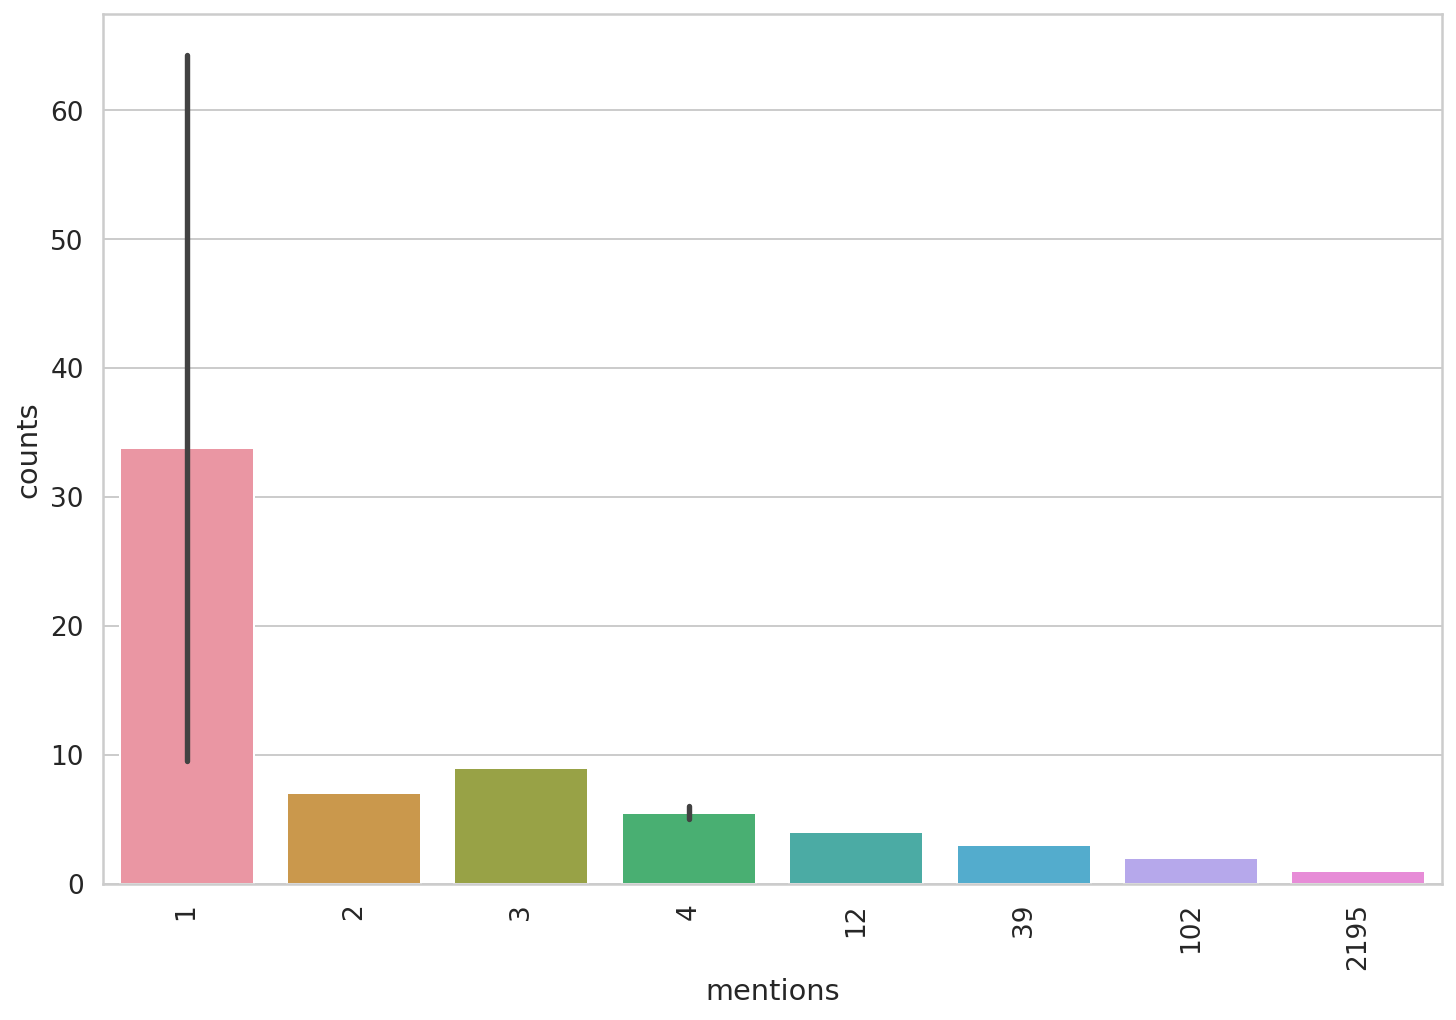

In [25]:
counts = mentions.value_counts().to_frame().reset_index()
counts.columns = ['mentions','counts']
counts_of_counts = counts.groupby('counts').count().reset_index()

ax = sns.barplot(x = counts_of_counts.mentions, y = counts_of_counts.counts)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

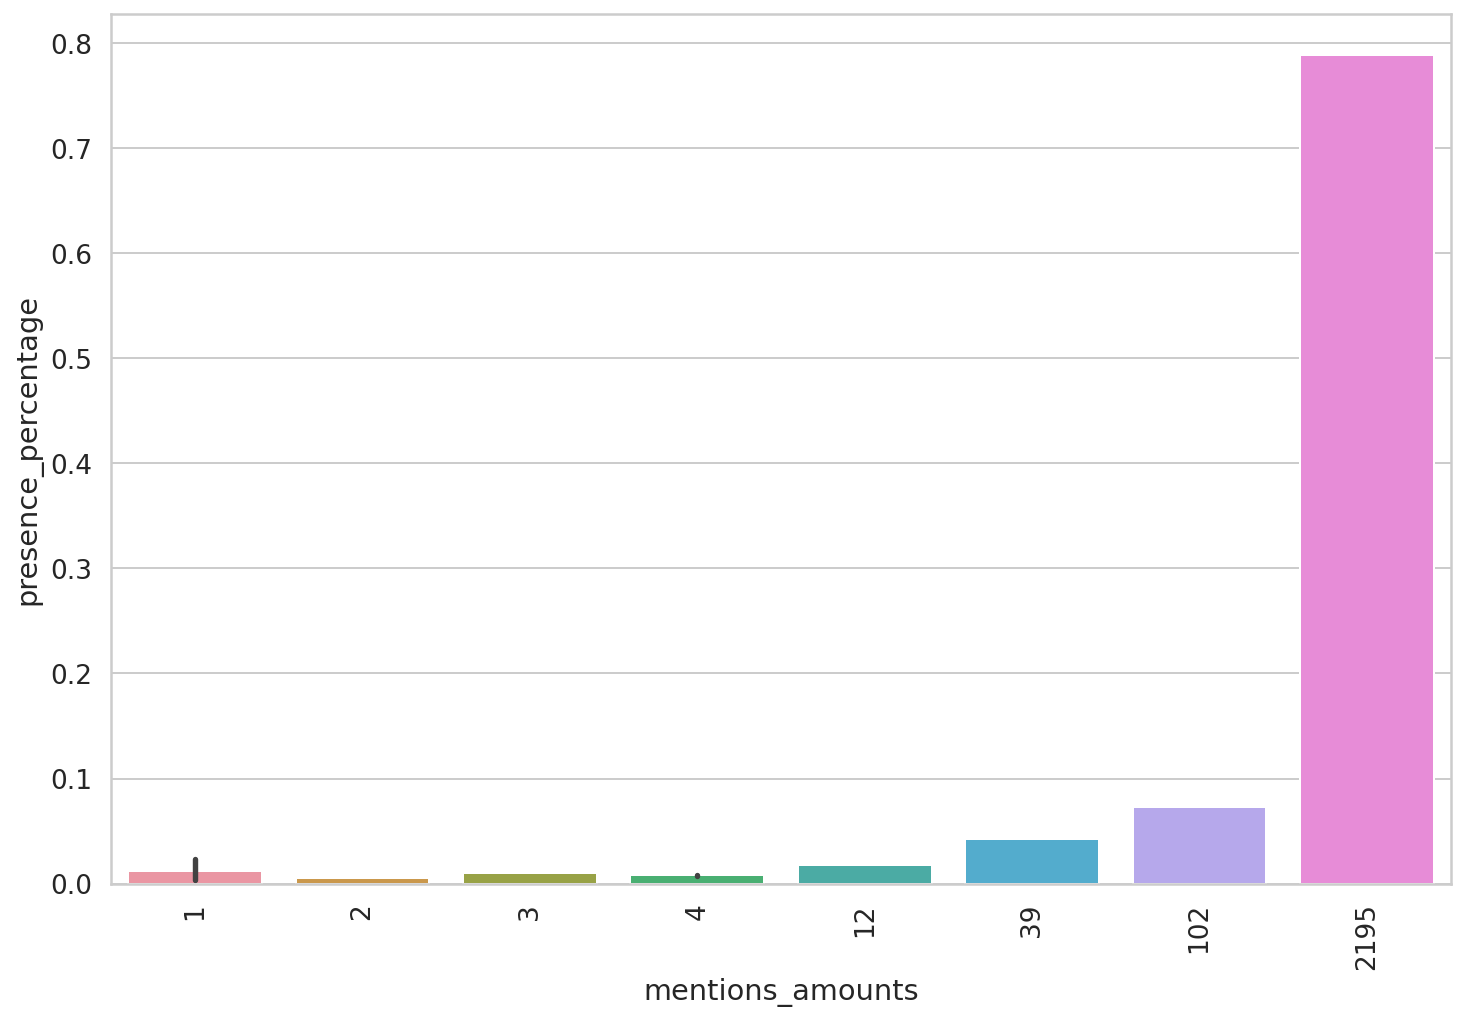

In [26]:
total_mentions = len(mentions)

counts_of_counts['presence_percentage'] = counts_of_counts.counts * counts_of_counts.mentions / total_mentions
counts_of_counts.columns = ['counts','mentions_amounts','presence_percentage']

ax = sns.barplot(x = counts_of_counts.mentions_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [27]:
counts_of_counts = counts_of_counts.sort_values('counts', ascending = False).reset_index()
counts_of_counts.head()

index  counts  mentions_amounts  presence_percentage
0     11      82                 1             0.029454
1     10      34                 1             0.012213
2      9      11                 1             0.003951
3      8       9                 3             0.009698
4      7       8                 1             0.002874

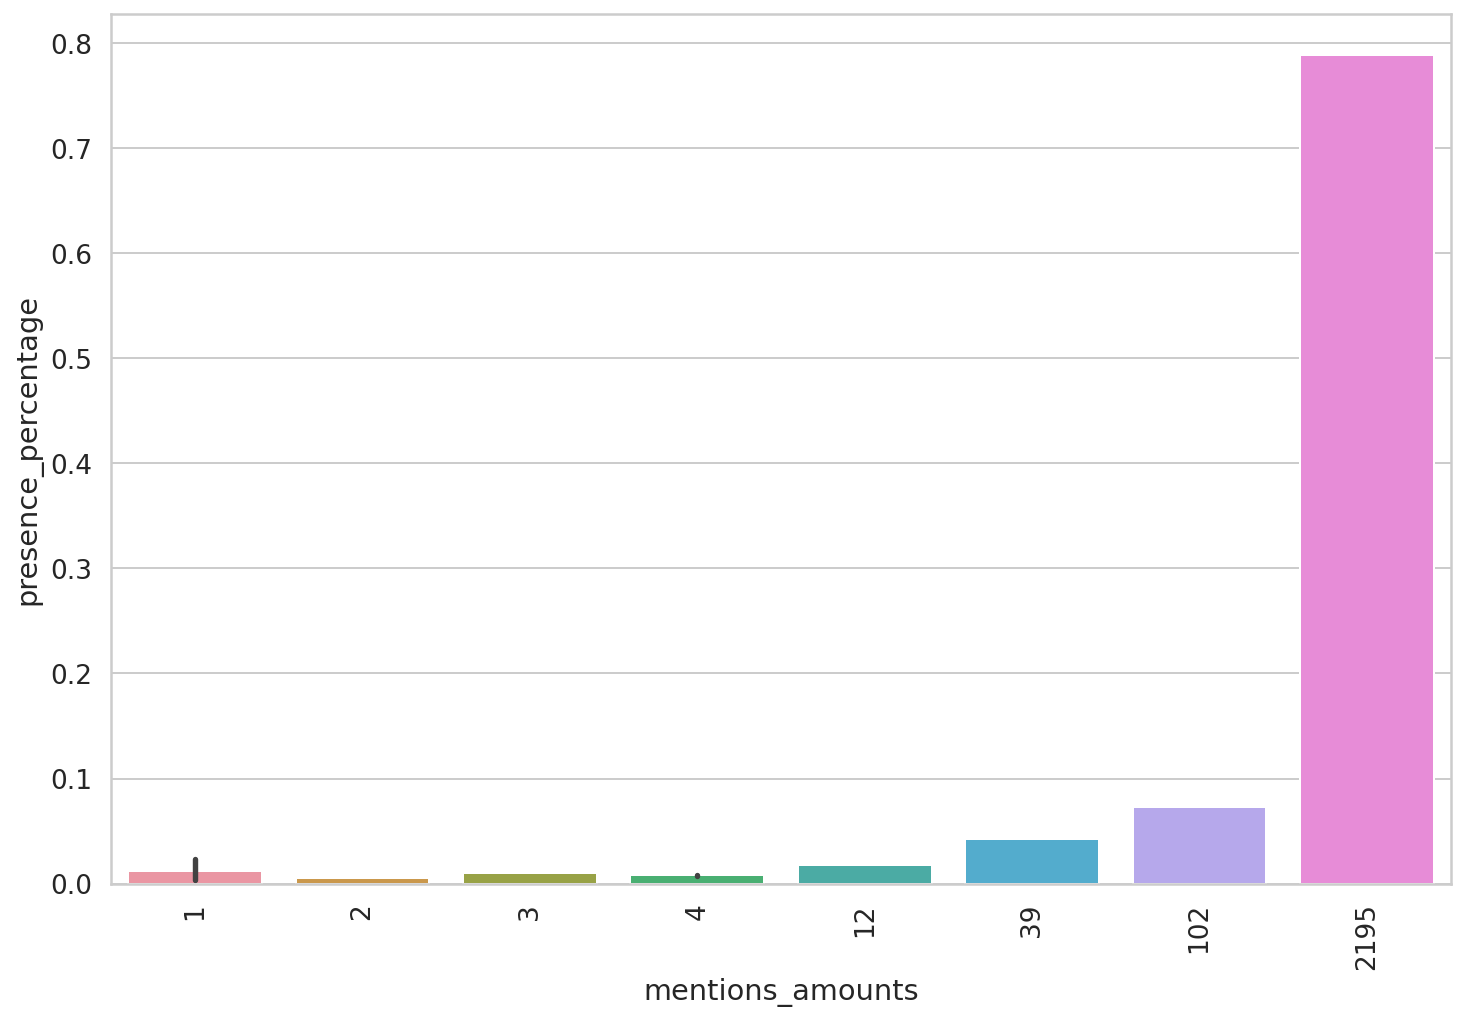

In [28]:
class_idx = 0
cumulated_prescence = 0
for idx,mention_class in counts_of_counts.iterrows():
    cumulated_prescence += mention_class.presence_percentage
    if cumulated_prescence >= 0.5:
        class_idx = idx
        break


to_filter_counts_of_counts = counts_of_counts.iloc[class_idx + 1:]
counts_of_counts = counts_of_counts.iloc[:class_idx + 1]
        
ax = sns.barplot(x = counts_of_counts.mentions_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [29]:
counts_of_counts.nlargest(1,'presence_percentage')

index  counts  mentions_amounts  presence_percentage
11      0       1              2195             0.788434

Aca pasa algo especial. Las demas clases sumadas no superan a la clase de las menciones con baja ocurrencia.

Sabiendo que la clase de mayor presencia son menciones de ocurrencia 1, vamos a proceder a eliminar esa clase por mas que clase esta constituya el 79% de las menciones porque esto no es mas que ruido inecesario.

In [30]:
to_filter_counts_of_counts = counts_of_counts.iloc[11:]
counts_of_counts = counts_of_counts.iloc[:11]

In [31]:
to_filter_counts_of_counts

index  counts  mentions_amounts  presence_percentage
11      0       1              2195             0.788434

In [32]:
print("Cantidad de menciones que quedan: ",int(counts_of_counts.presence_percentage.sum() * total_mentions))
print("Cantidad de menciones que que habia: ",total_mentions)
print(f"Porcentaje filtrado por baja ocurrencia: {round(1 - counts_of_counts.presence_percentage.sum(),3)*100}%")

Cantidad de menciones que quedan:  589
Cantidad de menciones que que habia:  2784
Porcentaje filtrado por baja ocurrencia: 78.8%


In [33]:
MENTION = ' MENTION '

to_filter_mentions = counts.merge(
        to_filter_counts_of_counts, on='counts'
).mentions.values

cleanMentions = lambda x: MENTION if x.group(0) in to_filter_mentions else ' ' + x.group(0)

# Links

In [34]:
links_pattern = re.compile('https?://\S+|www\.\S+')
links = pd.Series(re.findall(links_pattern,corpus))
links

0       http://t.co/lHYXEOHY6C
1       http://t.co/YAo1e0xngw
2       http://t.co/2nndBGwyEi
3       http://t.co/qqsmshaJ3N
4       http://t.co/3ImaomknnA
                 ...          
4726    http://t.co/3SICroAaNz
4727    http://t.co/I27Oa0HISp
4728    http://t.co/STfMbbZFB5
4729    http://t.co/zDtoyd8EbJ
4730    http://t.co/YmY4rSkQ3d
Length: 4731, dtype: object

In [35]:
print("Canitdad de links en el corpus: ",len(links))
print("Canitdad de links unicos en el corpus: ",len(set(links)))
counts = links.value_counts()
counts

Canitdad de links en el corpus:  4731
Canitdad de links unicos en el corpus:  4606


http://t.co/qew4c5M1xd       9
http://t.co/KSAwlYuX02       6
http://t.co/q2eBlOKeVE       6
http://t.co/eNCmhz6y34       6
http://t.co/cybKsXHF7d       5
                            ..
http://t.co/qYn6KxJSTl       1
http://t.co/6e7hHfeRz4       1
http://t.co/WnowfVCbMs...    1
http://t.co/rqKK15uhEY       1
http://t.co/oLdjsowKY5       1
Length: 4606, dtype: int64

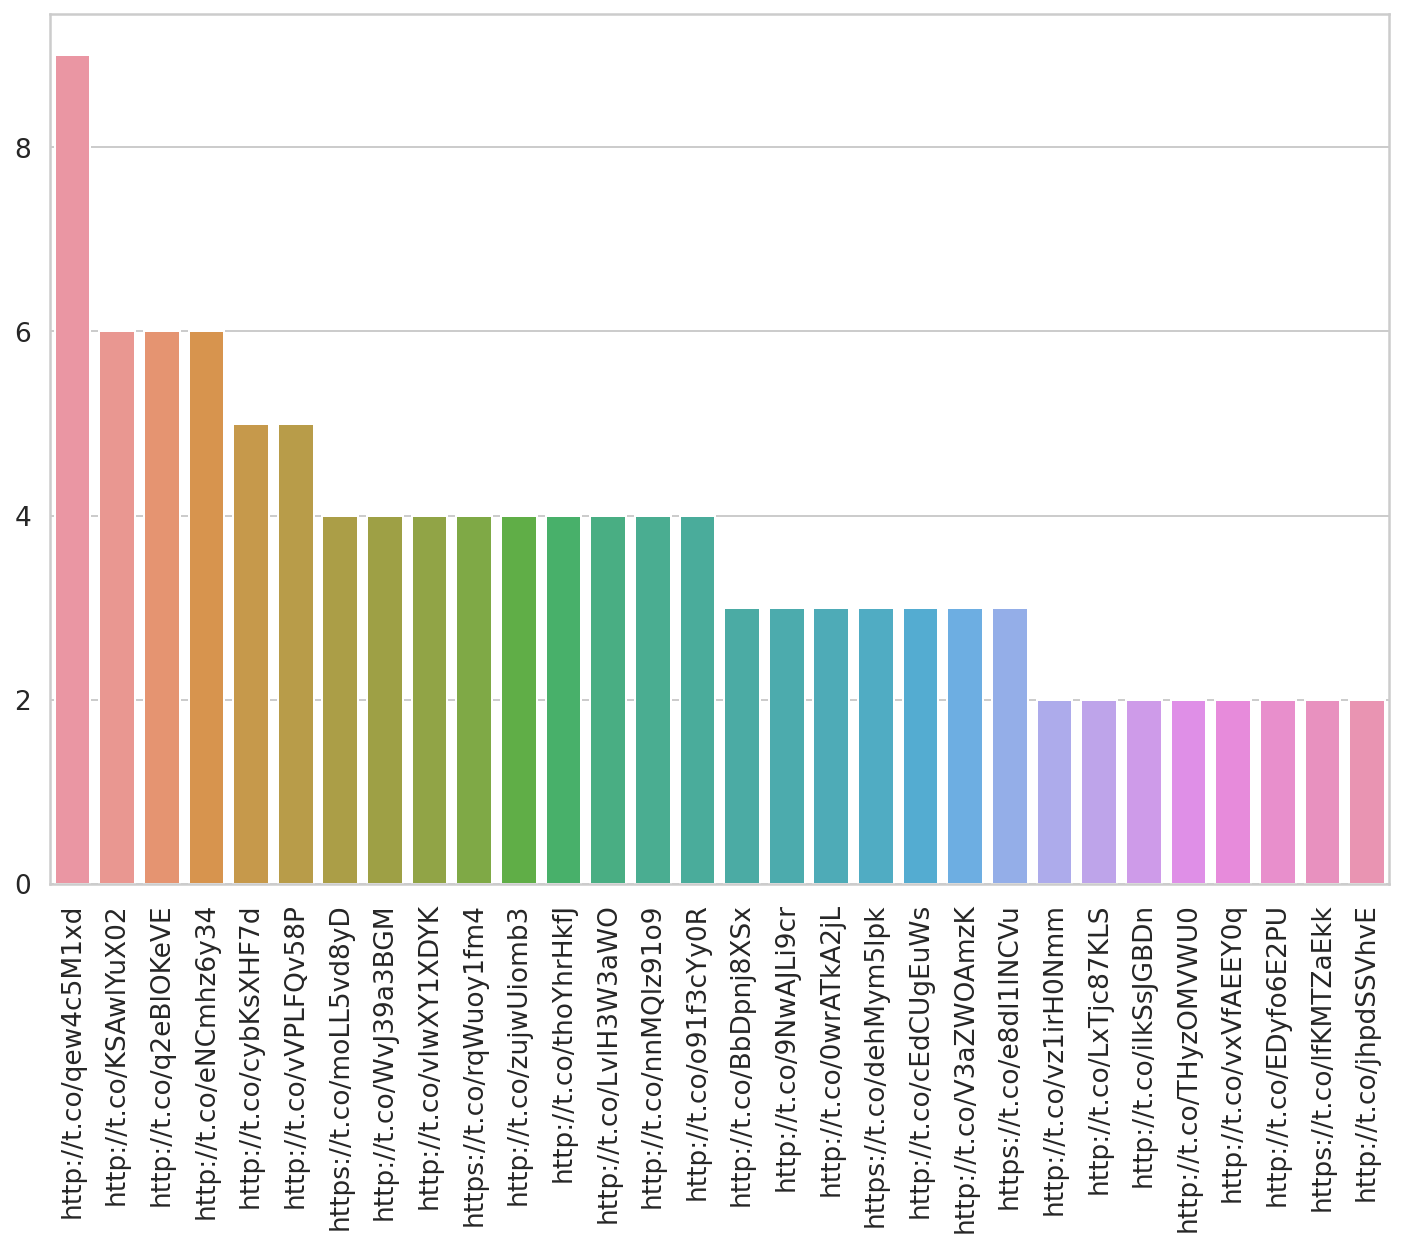

In [36]:
amount = 30
ax = sns.barplot(x = counts.head(amount).index, y = counts.head(amount).values)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Aparentemente hay algunos links que se repiten asi que vamos a tener una consideracion tambien por los links mas repetidos.

De todas formas si resulta que la repeticion no es tan marcada es posible que terminemos mapeando todos los links a LINK por las razones antes decriptas en los hashtags y menciones

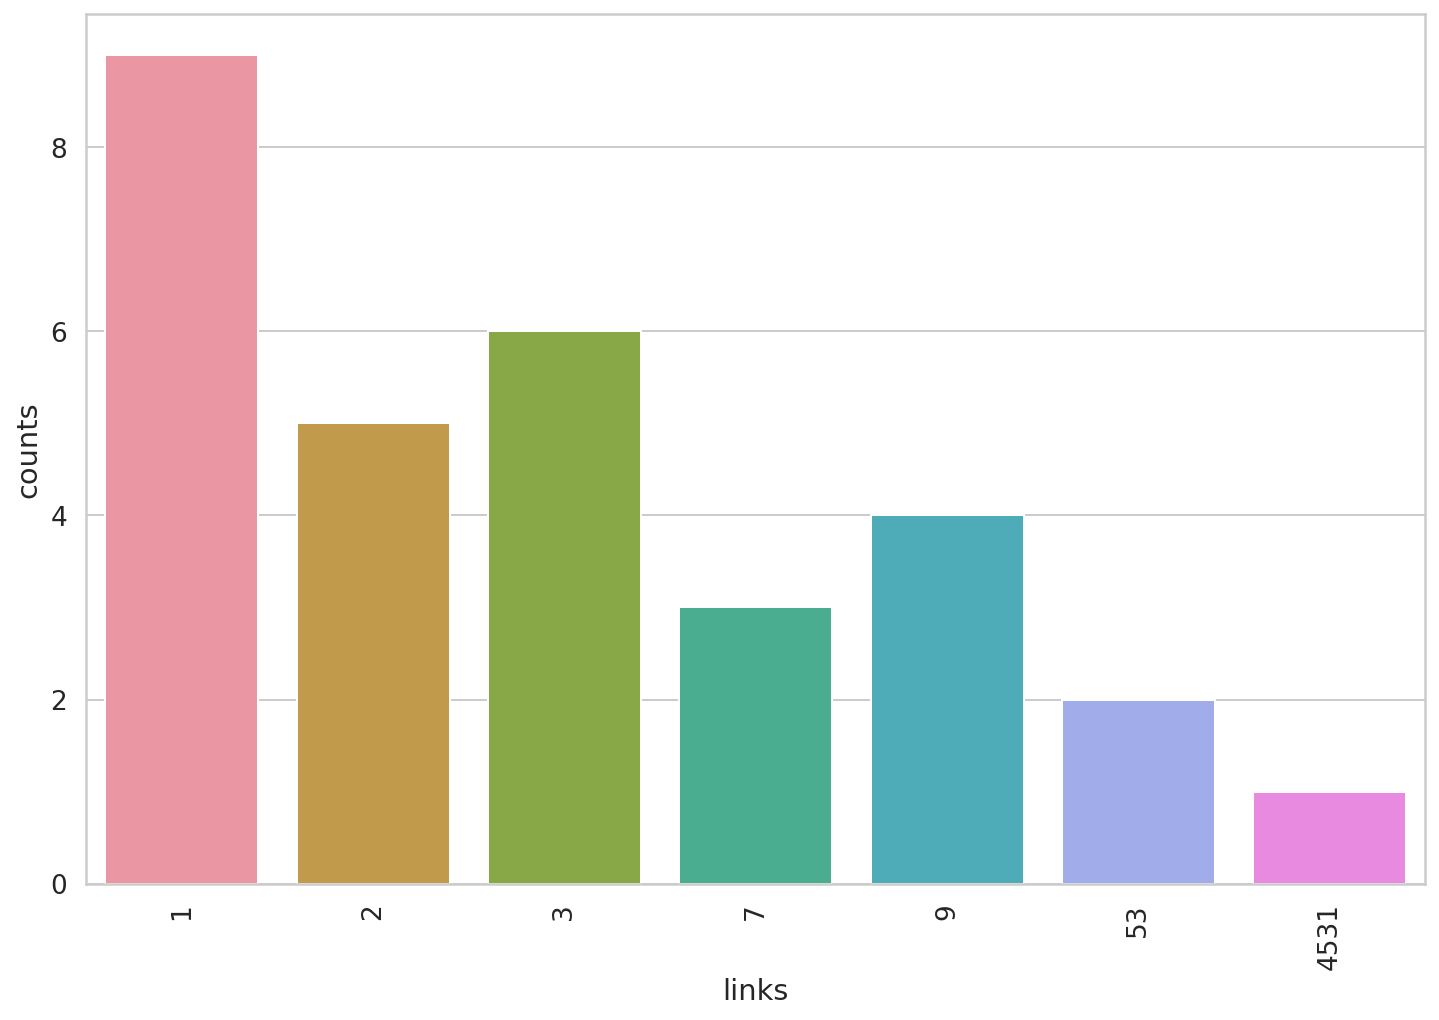

In [37]:
counts = links.value_counts().to_frame().reset_index()
counts.columns = ['links','counts']
counts_of_counts = counts.groupby('counts').count().reset_index()

ax = sns.barplot(x = counts_of_counts.links, y = counts_of_counts.counts)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

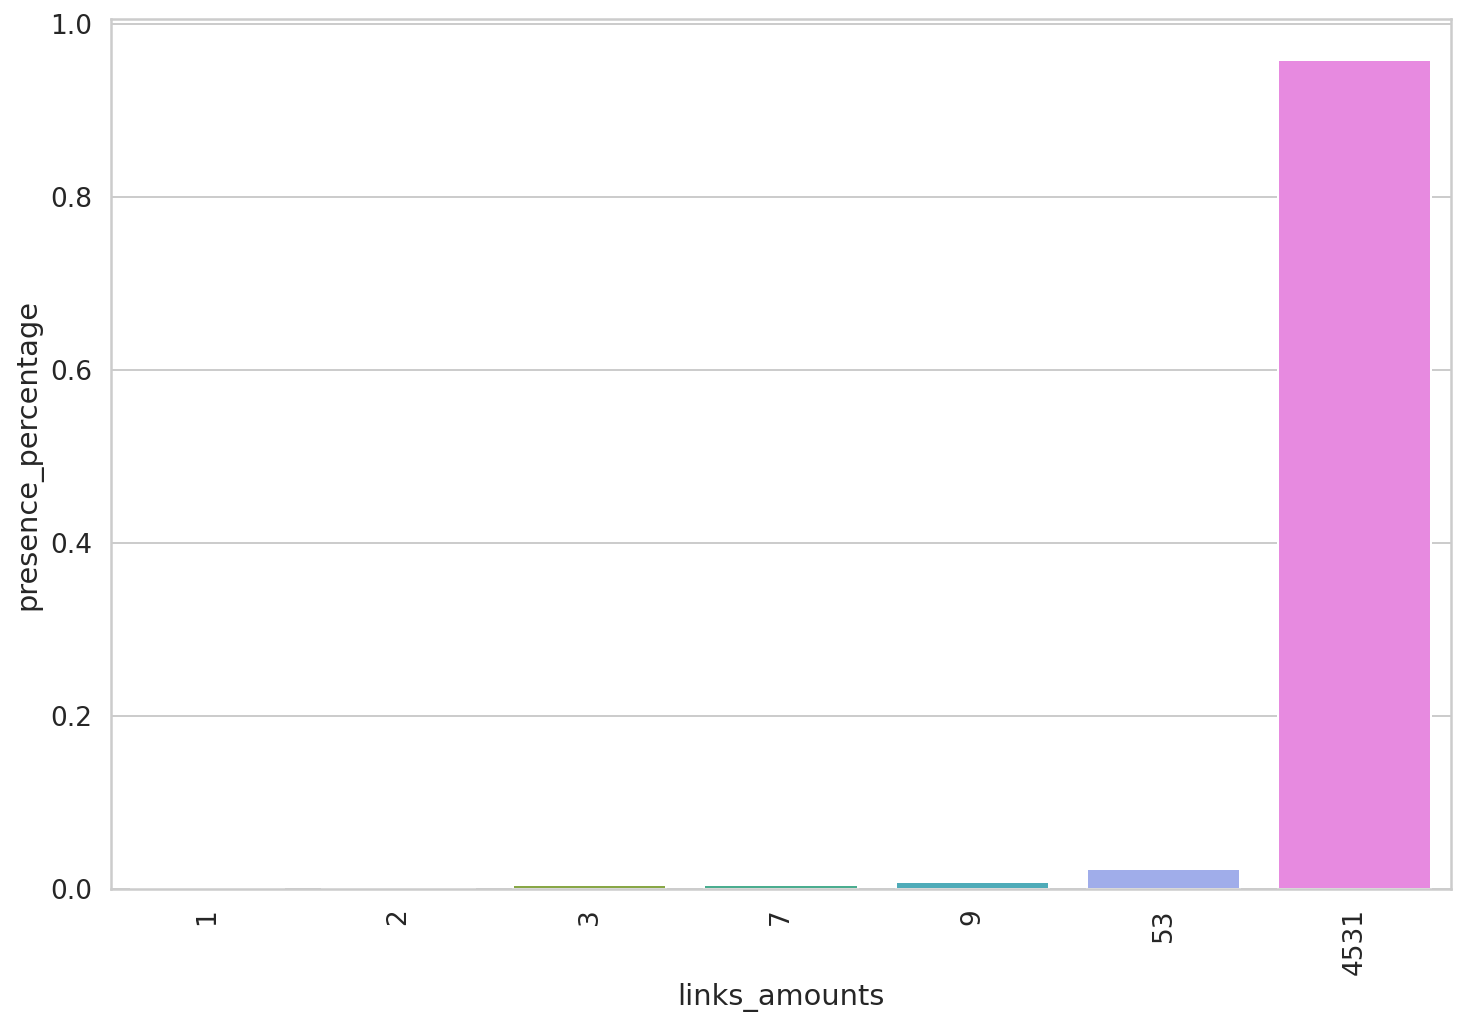

In [38]:
total_links = len(links)

counts_of_counts['presence_percentage'] = counts_of_counts.counts * counts_of_counts.links / total_links
counts_of_counts.columns = ['counts','links_amounts','presence_percentage']

ax = sns.barplot(x = counts_of_counts.links_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Aca esta clarisimo que la grandisima mayoria de links solo se repiten una vez en todo el corpus por lo que de entrada vamos a descartar esa clase

In [39]:
counts_of_counts = counts_of_counts.sort_values('counts', ascending = False).reset_index()
counts_of_counts.head()

index  counts  links_amounts  presence_percentage
0      6       9              1             0.001902
1      5       6              3             0.003805
2      4       5              2             0.002114
3      3       4              9             0.007609
4      2       3              7             0.004439

In [40]:
to_filter_counts_of_counts = counts_of_counts.iloc[-1:]
counts_of_counts = counts_of_counts.iloc[:-1]

to_filter_counts_of_counts

index  counts  links_amounts  presence_percentage
6      0       1           4531             0.957726

In [41]:
print("Cantidad de links que quedan: ",counts_of_counts.presence_percentage.sum() * total_links)
print("Cantidad de links que que habia: ",total_links)
print(f"Porcentaje filtrado por baja ocurrencia: {round(1 - counts_of_counts.presence_percentage.sum(),3)*100}%")

Cantidad de links que quedan:  200.0
Cantidad de links que que habia:  4731
Porcentaje filtrado por baja ocurrencia: 95.8%


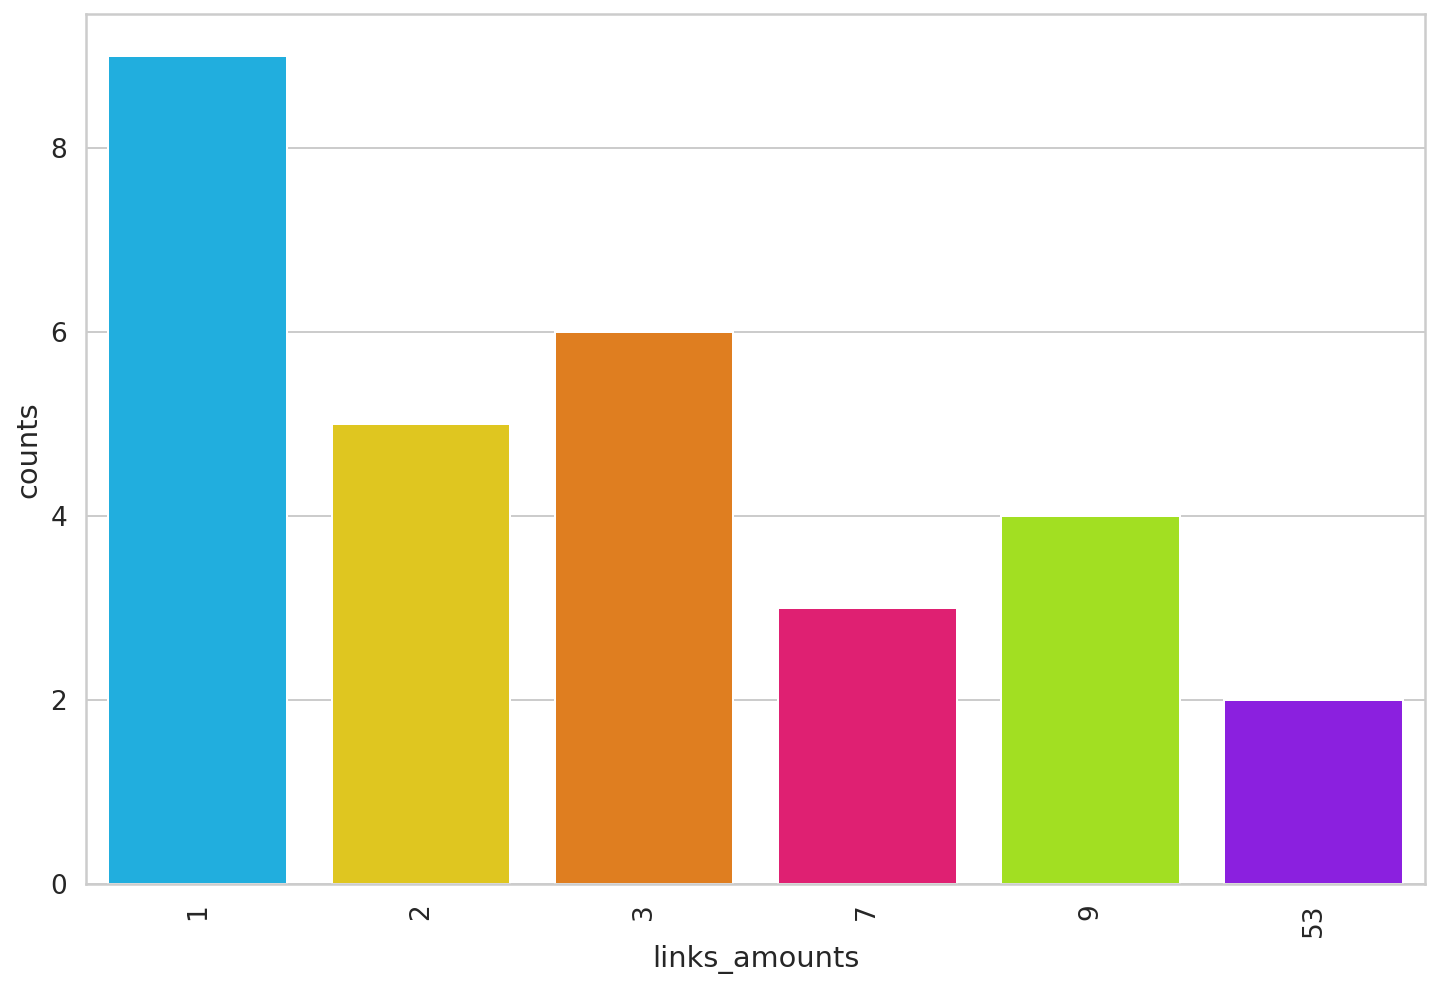

In [42]:
ax = sns.barplot(x = counts_of_counts.links_amounts, y = counts_of_counts.counts)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Habiendo filtrado los links que solo aparecen una vez vemos que los restantes ya de por si son pocos y ademas siguen apareciendo poco (los mas frecuentes solo son 1 y aparece solo 9 veces!)

Esto nos lleva a mapear TODOS los links a un tag LINK

In [43]:
LINK = ' LINK '
cleanLinks = lambda x: LINK

# Texto con codigo HTML

In [44]:
html_pattern = re.compile('<.*?>')
htmls = pd.Series(re.findall(html_pattern,corpus))
htmls

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Series([], dtype: float64)

In [45]:
HTML = ' HTML '
cleanHTMLS = lambda x: HTML

No hay. Mejor, menos trabajo

# Emojis

In [46]:
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
emojis = pd.Series(re.findall(emoji_pattern,corpus))
emojis

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


Series([], dtype: float64)

Tampoco hay. Genial

In [47]:
EMOJI = ' EMOJI '
cleanEmojis= lambda x: EMOJI

# Mails

In [48]:
mails_pattern = re.compile('\S+@\S+.com')
mails = pd.Series(re.findall(mails_pattern,corpus))
mails

0           heccfidmss@gmail.com
1       'fuckface@wineisdumb.com
2     everydaynigerian@gmail.com
3    contactSimpleNews@gmail.com
4          Ashxjonespr@gmail.com
5     zboyer@washingtontimes.com
6    TonyJ@Centralizedhockey.com
7            cigarknub@gmail.com
8          Lovethterry@gmail.com
dtype: object

Son realmente pocos y no se reptien asi que mapeamos todos a MAIL

In [49]:
MAIL = ' MAIL '
cleanMails = lambda x: MAIL

# Fechas y Horas

In [50]:
common_times_names = '|'.join([
    'Jan','Feb','May','Apr','March', 'Jun','July','Agugust', 'Sept','Nov','December',
    'Mond','Thurs', 'Wednes','Tues','Frid','Satur','Sunday',
    'Year','Month','Day','Week'
])
times_pattern_1 = re.compile('^.*('+common_times_names+').*$',
                           flags = re.IGNORECASE|re.M)
times = pd.Series(re.findall(times_pattern_1,corpus))

times_pattern_2 = re.compile('\d{2,4}[:/-]\d{2}[:/-]?\d{2,4}?')
times = pd.concat([times,pd.Series(re.findall(times_pattern_2,corpus))])

times_pattern_3 = re.compile('20\d{2}|19\d{2}')
times = pd.concat([times,pd.Series(re.findall(times_pattern_3,corpus))])

times_pattern_4 = re.compile('(?:1|2)\d[:]\d{2}')
times = pd.concat([times,pd.Series(re.findall(times_pattern_4,corpus))])

times

0      Sept
1      year
2       Jun
3      week
4       Day
      ...  
56    15:04
57    10:00
58    15:04
59    10:00
60    15:41
Length: 746, dtype: object

In [51]:
print("Canitdad de tiempos en el corpus: ",len(times))
print("Canitdad de tiempos unicos en el corpus: ",len(set(times)))
counts = times.value_counts()
counts

Canitdad de tiempos en el corpus:  746
Canitdad de tiempos unicos en el corpus:  170


2015        124
day         123
year         45
may          25
2000         23
           ... 
2006          1
18:22         1
17:26         1
158-0853      1
751-0880      1
Length: 170, dtype: int64

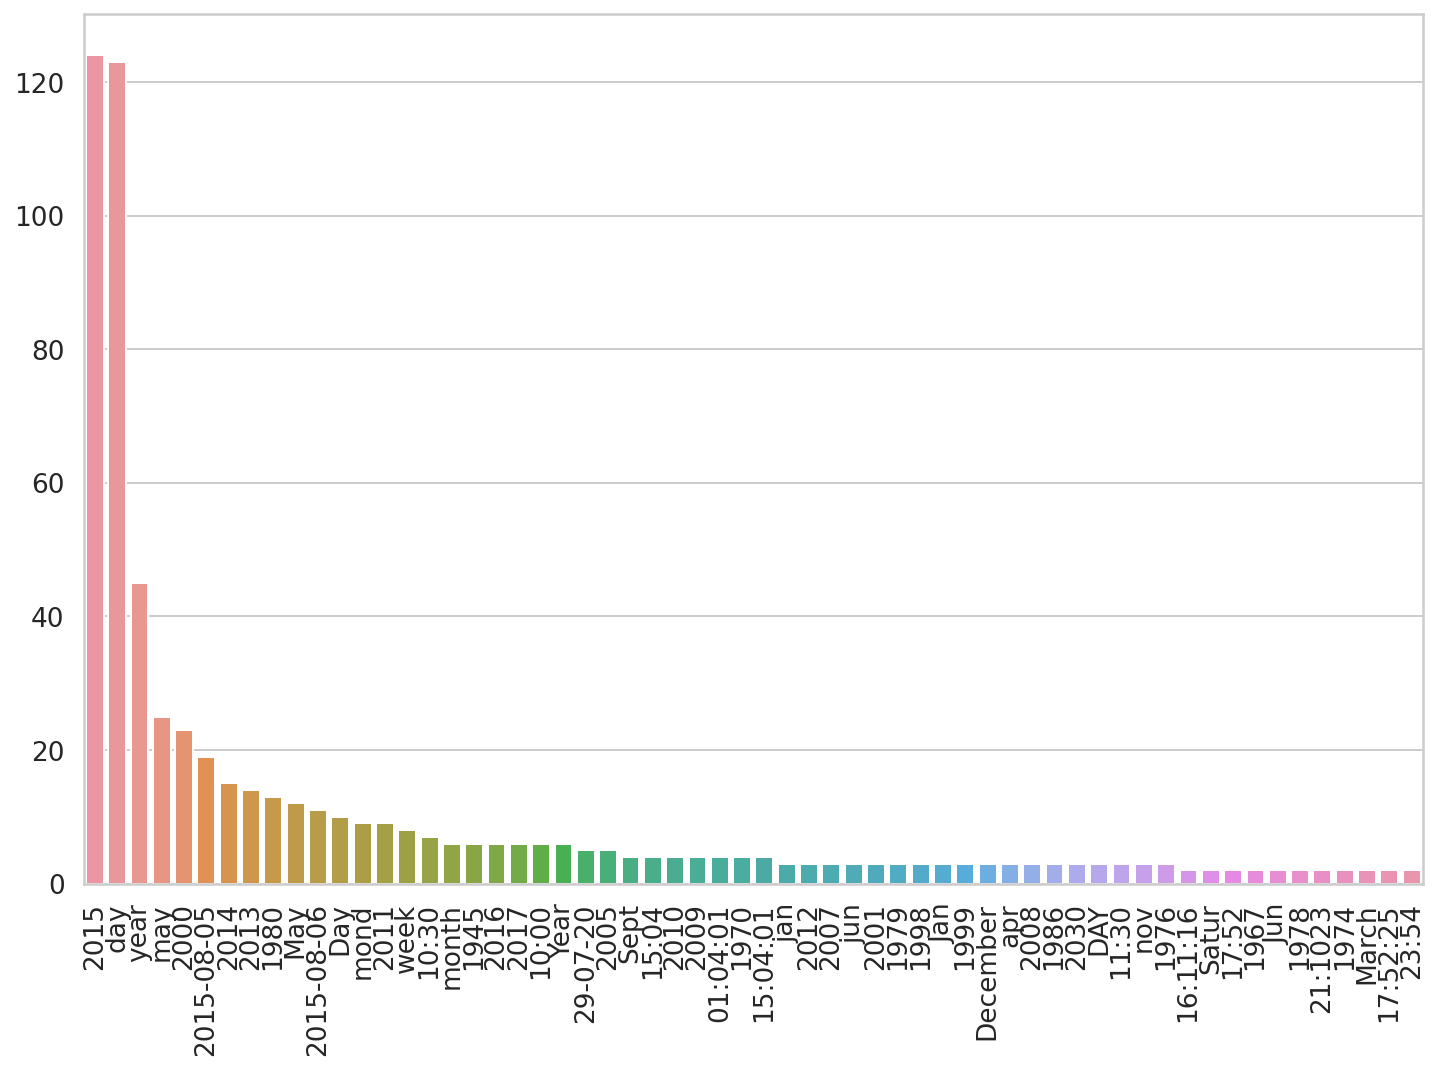

In [52]:
amount = 60
ax = sns.barplot(x = counts.head(amount).index, y = counts.head(amount).values)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

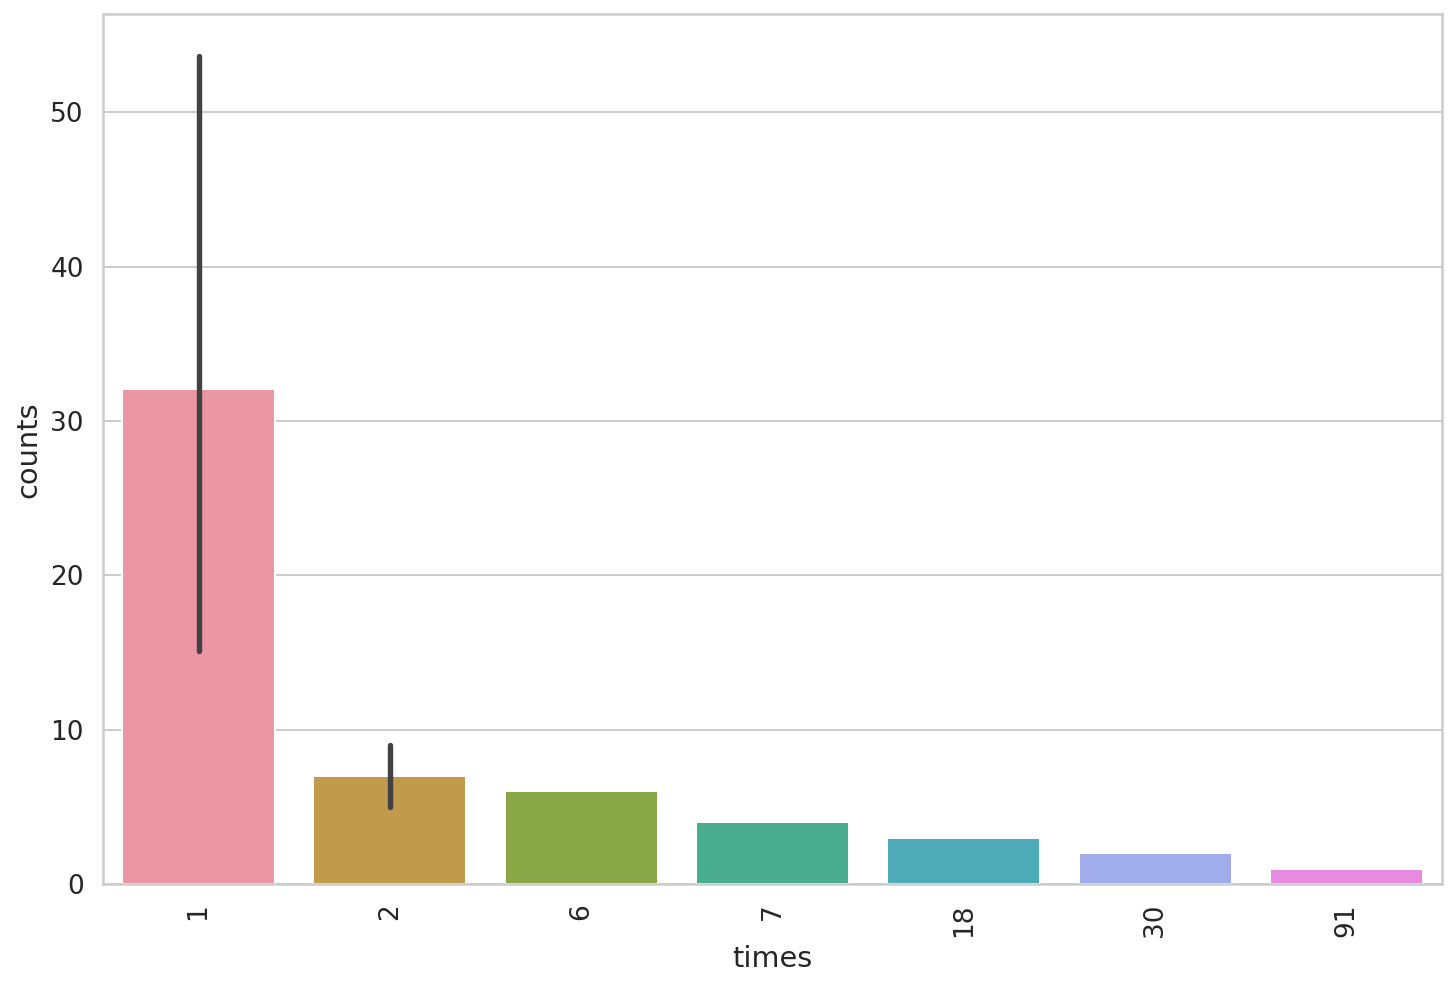

In [53]:
counts = times.value_counts().to_frame().reset_index()
counts.columns = ['times','counts']
counts_of_counts = counts.groupby('counts').count().reset_index()

ax = sns.barplot(x = counts_of_counts.times, y = counts_of_counts.counts)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

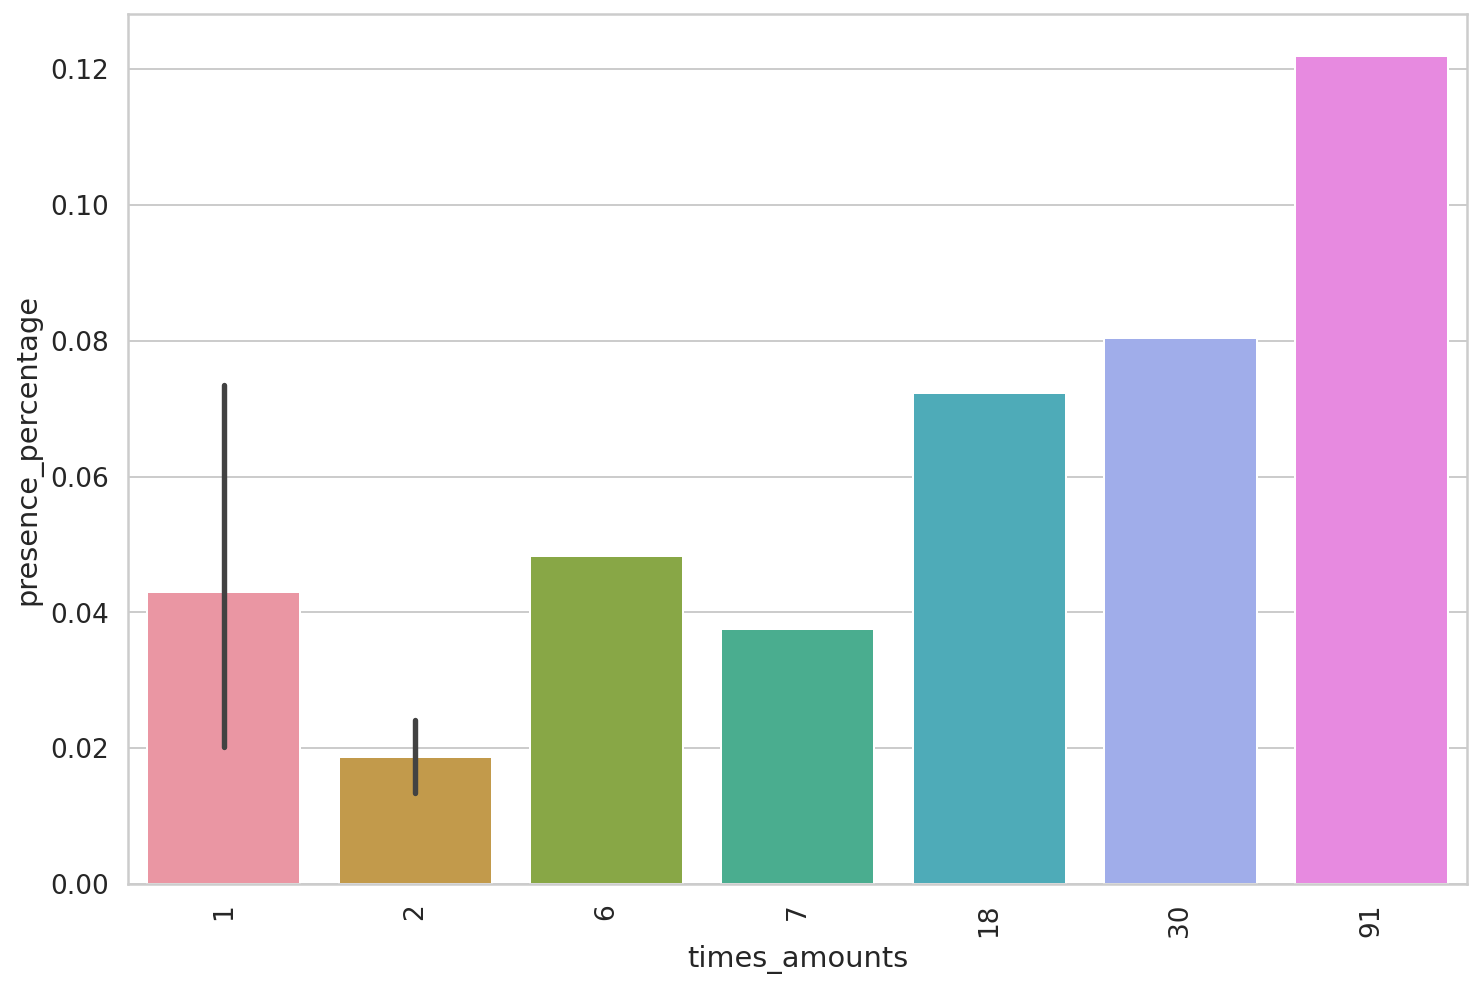

In [54]:
total_times = len(times)

counts_of_counts['presence_percentage'] = counts_of_counts.counts * counts_of_counts.times / total_times
counts_of_counts.columns = ['counts','times_amounts','presence_percentage']

ax = sns.barplot(x = counts_of_counts.times_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [55]:
counts_of_counts.presence_percentage.sum()

1.0

In [56]:
counts_of_counts = counts_of_counts.sort_values('counts', ascending = False).reset_index()
counts_of_counts.head()

index  counts  times_amounts  presence_percentage
0     20     124              1             0.166220
1     19     123              1             0.164879
2     18      45              1             0.060322
3     17      25              1             0.033512
4     16      23              1             0.030831

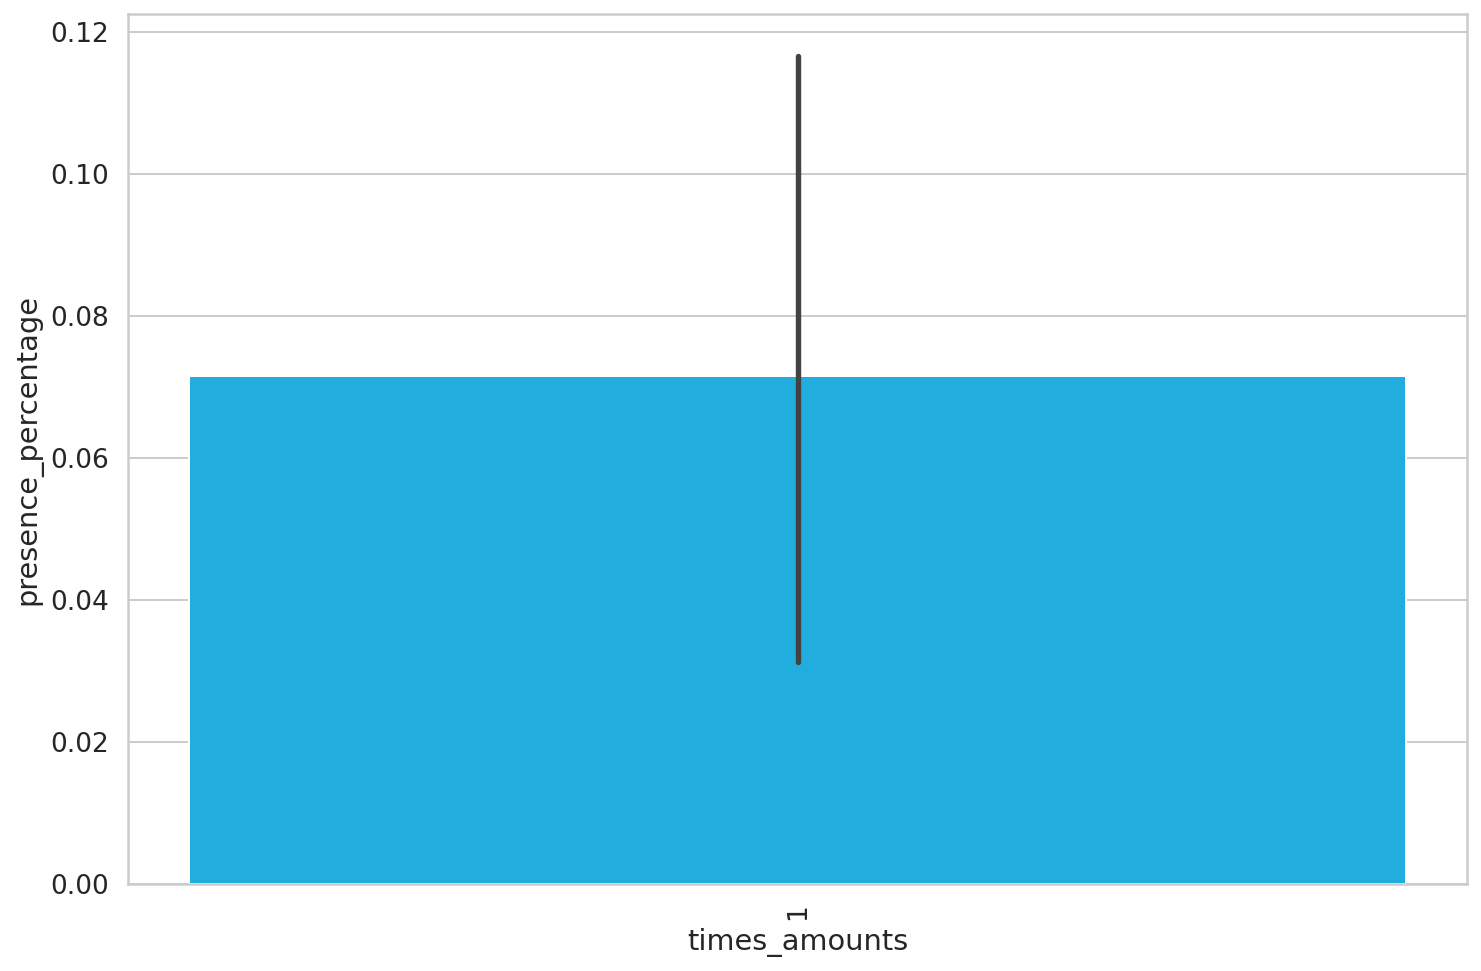

In [57]:
class_idx = 0
cumulated_prescence = 0
for idx,times_class in counts_of_counts.iterrows():
    cumulated_prescence += times_class.presence_percentage
    if cumulated_prescence >= 0.5:
        class_idx = idx
        break


to_filter_counts_of_counts = counts_of_counts.iloc[class_idx + 1:]
counts_of_counts = counts_of_counts.iloc[:class_idx + 1]
        
ax = sns.barplot(x = counts_of_counts.times_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [58]:
print("Cantidad de tiempos que quedan: ",counts_of_counts.presence_percentage.sum() * total_times)
print("Cantidad de tiempos que que habia: ",total_times)
print(f"Porcentaje filtrado por baja ocurrencia: {round(1 - counts_of_counts.presence_percentage.sum(),3)*100}%")

Cantidad de tiempos que quedan:  374.0
Cantidad de tiempos que que habia:  746
Porcentaje filtrado por baja ocurrencia: 49.9%


In [59]:
to_filter_counts_of_counts

index  counts  times_amounts  presence_percentage
7      13      14              1             0.018767
8      12      13              1             0.017426
9      11      12              1             0.016086
10     10      11              1             0.014745
11      9      10              1             0.013405
12      8       9              2             0.024129
13      7       8              1             0.010724
14      6       7              1             0.009383
15      5       6              6             0.048257
16      4       5              2             0.013405
17      3       4              7             0.037534
18      2       3             18             0.072386
19      1       2             30             0.080429
20      0       1             91             0.121984

Estos que se muestran a continuacion son los tiempos que no se van a filtrar por su elevada ocurrencia

In [60]:
counts.merge(
        counts_of_counts, on='counts'
).times.values

array(['2015', 'day', 'year', 'may', '2000', '2015-08-05', '2014'],
      dtype=object)

Vemos que la gran mayoria de tiempos (y en particular fechas) no tienen mucha frecuencia.

Esto es un gran alivio porque de haber tenido mucha frecuencia esto hubiese significado que estabamos contando con un set de datos ordenado temporalmente. Cosa que complejiza el problema.

Con esto descartamos esta hipotesis o al menos descartamos que podamos hacer algo al respecto.

Llama la atencion que 2015 sea un valor frecuente. Quizas el dataset sea de ese año

In [61]:
TIME = ' TIME '

to_filter_times = counts.merge(
        to_filter_counts_of_counts, on='counts'
).times.values

cleanTimes = lambda x: TIME if x.group(0) in to_filter_times else ' ' + x.group(0)

# Simbolos raros

Vamos a ocuparnos de quitar esos simbolos raros de formato \x86...

In [62]:
weird_pattern = re.compile('[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]')
weirds = pd.Series(re.findall(weird_pattern,corpus))
' '.join(weirds)

'\x89 Û Ò \x89 Û Ó \x89 Û Ó å Ê \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 ã ¢ \x89 ã ¢ \x89 Û Ò \x89 Û Ò \x89 Û \x89 Û å Ê \x89 Û Ï \x89 Û \x9d \x89 Û ª \x89 Û Ò \x89 Û \x89 Û ÷ \x89 Û ª \x89 Û Ï \x89 Û \x9d \x89 Û å Ê å Ê \x89 Û \x89 Û Ó \x89 Û ¢ \x89 Û ¢ å Ê \x89 Û ÷ å Ê \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û ª \x89 Û Ï \x89 Û \x9d \x89 Û Ò \x89 Û \x89 Û \x89 Û Ì Ñ \x89 Û ÷ \x89 Û ª \x89 Û ÷ \x89 Û ª \x89 Û Ê \x89 Û Ê \x89 Û Ê \x89 Û ÷ \x89 Û ª \x89 Û ÷ \x89 Û ª \x89 Û ÷ \x89 Û ª \x89 Û \x89 Û ª \x89 Û \x89 Û Ï \x89 Û \x9d \x89 Û ª \x89 Û ¢ \x89 Û ¢ \x89 Û Ï \x89 Û \x9d \x89 Û Ï \x89 Û \x9d Ì £ \x89 Û ÷ \x89 Û ª \x89 Û Ì Ñ å Ê \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û \x89 Û Ò \x89 Û \x89 Û \x89 Û \x89 Û Ì ¬ Ì ¢ Ì £ \x89 Û \x89 Û ª \x89 Û ÷ \x89 Û ª \x89 Û \x89 Û Ó Ì Ï \x89 Û ª \x89 Û ª \x89 Û ª \x89 Û Ò \x89 Û \x89 Û å £ \x89 Û å ¤ \x89 Û \x89 Û \x89 Û Ì ü \x89 Û \x89 Û \x89 Û å \x89 Û \x89 Û \x89 Û Ì Ï å Ê \x89 

Investigando un poco aparentemente este es un "simbolo de escape" del teclado. 

https://books.google.com.ar/books?id=WQPQEbGx73EC&pg=PT646&lpg=PT646&dq=meaning+uses+of+%22%5Cxnn%22&source=bl&ots=W8zyfDSpt-&sig=ACfU3U0H71KBqCZw4QE4z55-Zrn6xIhnog&hl=es&sa=X&ved=2ahUKEwiXw-eR4PjqAhVrIrkGHcQRCKwQ6AEwCHoECAkQAQ#v=onepage&q=meaning%20uses%20of%20%22%5Cxnn%22&f=false

Dicho de otra forma. No es nada con un significado semantico para nuestro tweet por lo que dependiendo de su distribucion y presencia en el corpus podemos o mapearlo todo a WEIRD o eliminarlo.

In [63]:
print("Canitdad de raros en el corpus: ",len(weirds))
print("Canitdad de raros unicos en el corpus: ",len(set(weirds)))
counts = weirds.value_counts()
counts

Canitdad de raros en el corpus:  2598
Canitdad de raros unicos en el corpus:  37


    838
Û    832
ª    191
å    126
Ì    105
Ï     89
Ê     71
÷     50
¢     48
Ò     45
     44
Ó     34
©     18
¡     17
£     16
¼      7
¨      6
È      6
Á      6
±      5
á      5
ã      5
ø      4
Ñ      4
«      3
Ç      3
ü      3
¬      3
¤      3
´      2
      2
¦      2
Â      1
ä      1
À      1
      1
â      1
dtype: int64

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 157 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 157 missing from current font.
  font.set_text(s, 0, fla

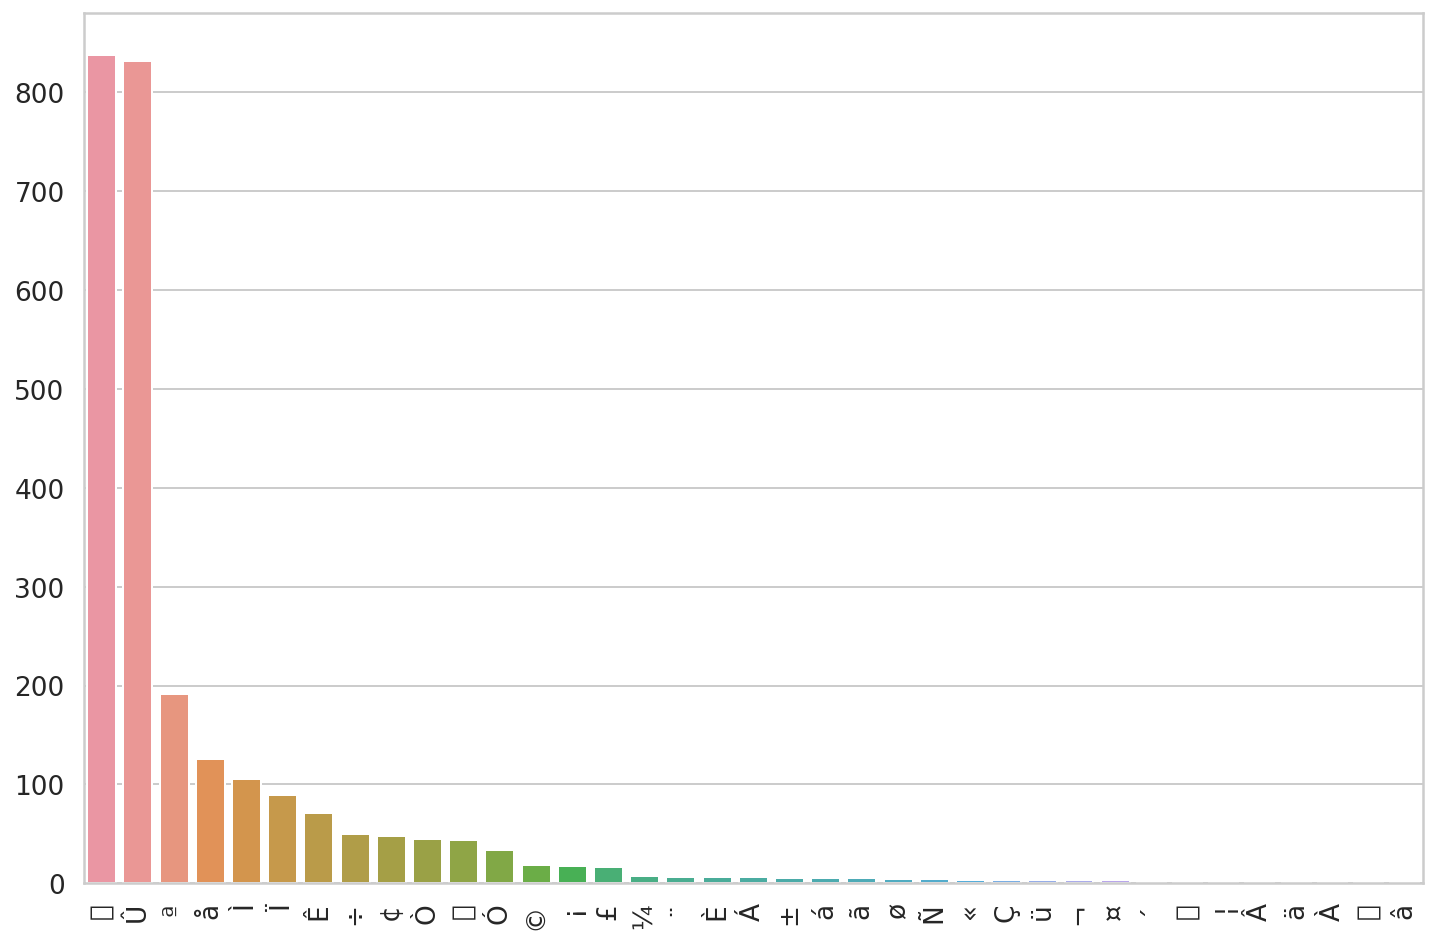

In [64]:
amount = 60
ax = sns.barplot(x = counts.head(amount).index, y = counts.head(amount).values)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Vemos que realmente no son tan pocos como para tirarlos.

Deberiamos ser lo mas agnosticos posible resepecto de que es semanticamente util para la data y mantener estos simbolos.

De todas formas la decision ahora pasa por mantener mapear todos a un tag o solo algunos.

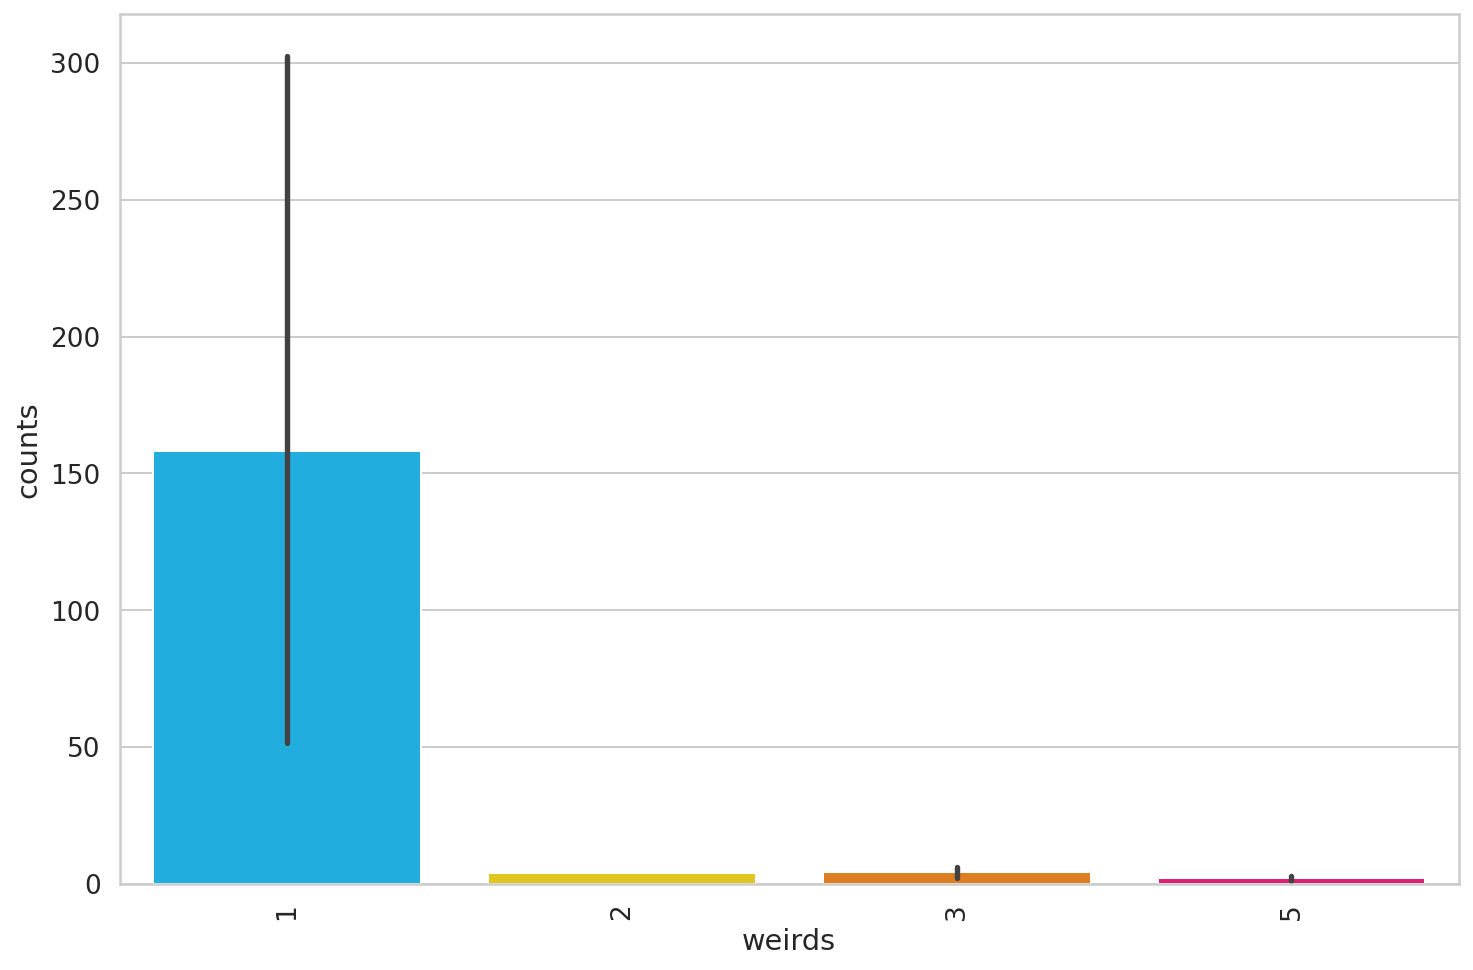

In [65]:
counts = weirds.value_counts().to_frame().reset_index()
counts.columns = ['weirds','counts']
counts_of_counts = counts.groupby('counts').count().reset_index()

ax = sns.barplot(x = counts_of_counts.weirds, y = counts_of_counts.counts)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

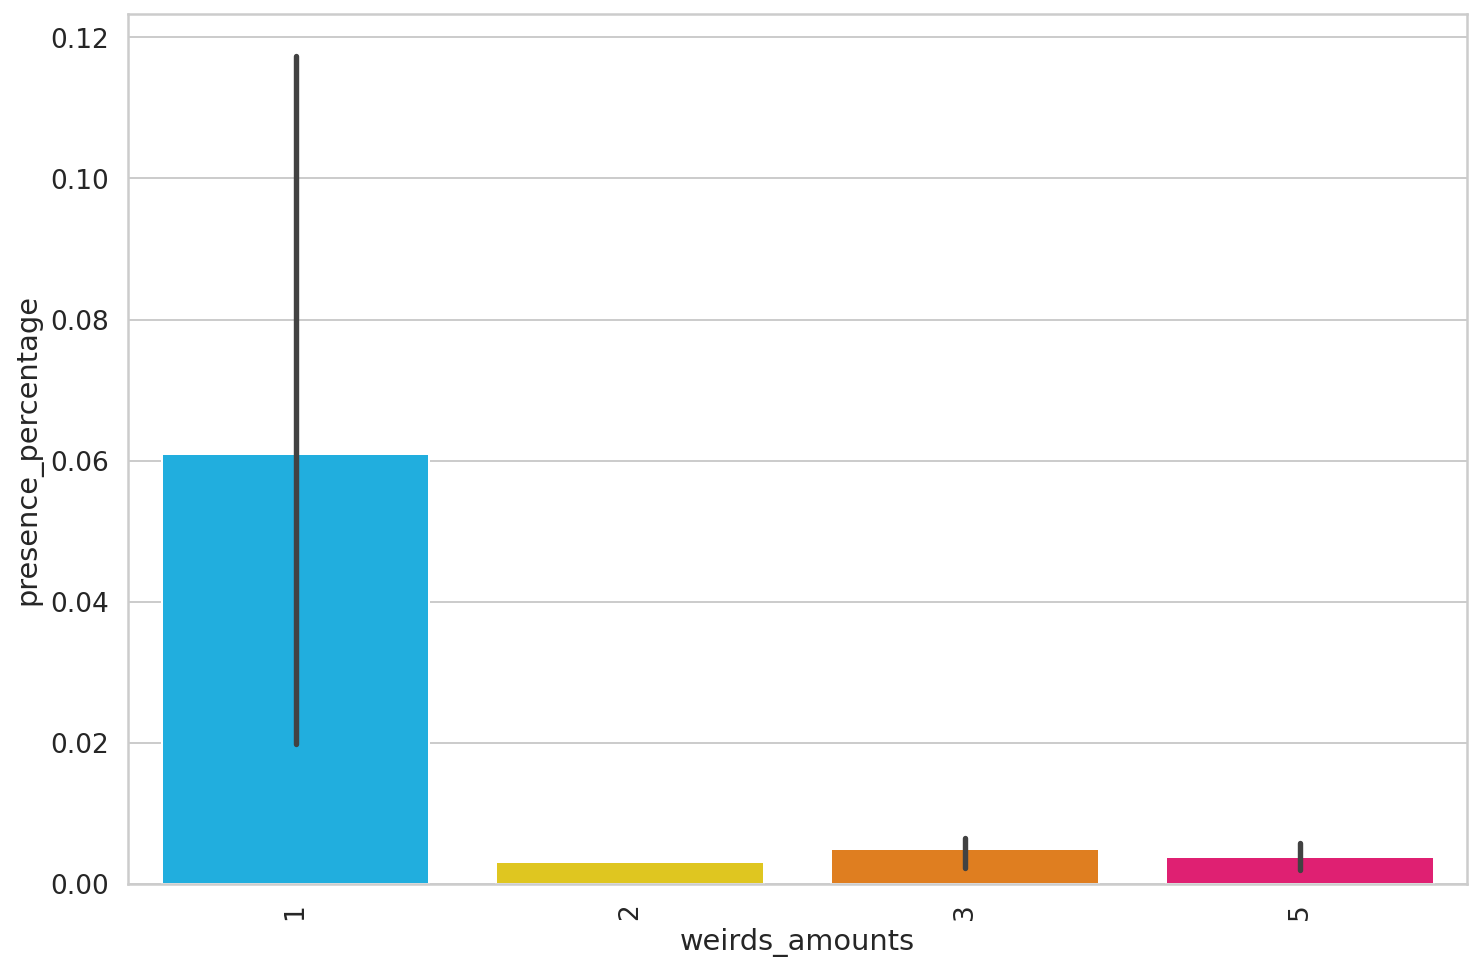

In [66]:
total_weirds = len(weirds)

counts_of_counts['presence_percentage'] = counts_of_counts.counts * counts_of_counts.weirds / total_weirds
counts_of_counts.columns = ['counts','weirds_amounts','presence_percentage']

ax = sns.barplot(x = counts_of_counts.weirds_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Es interesante ver que esta distribucion es parecida a la de palabras/simbolos relacionados con el tiempo y las fechas o la hora.

De haberlos desechado quizas hubiesemos estado tirando algo tan importante como el tiempo mismo!!!

In [67]:
counts_of_counts = counts_of_counts.sort_values('counts', ascending = False).reset_index()
counts_of_counts.head()

index  counts  weirds_amounts  presence_percentage
0     21     838               1             0.322556
1     20     832               1             0.320246
2     19     191               1             0.073518
3     18     126               1             0.048499
4     17     105               1             0.040416

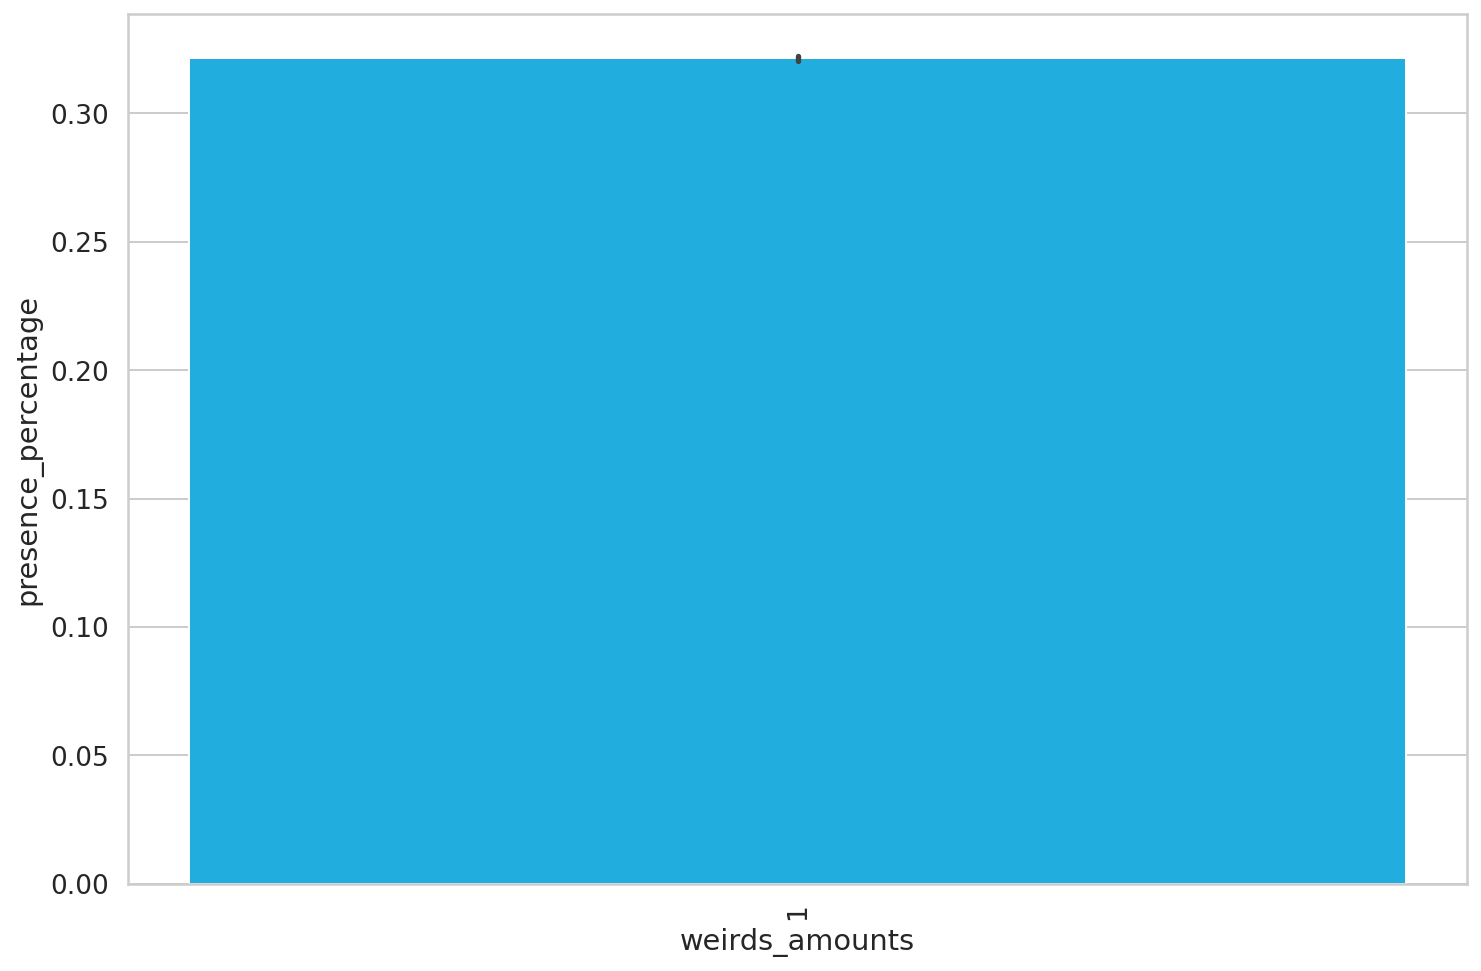

In [68]:
class_idx = 0
cumulated_prescence = 0
for idx,weirds_class in counts_of_counts.iterrows():
    cumulated_prescence += weirds_class.presence_percentage
    if cumulated_prescence >= 0.5:
        class_idx = idx
        break


to_filter_counts_of_counts = counts_of_counts.iloc[class_idx + 1:]
counts_of_counts = counts_of_counts.iloc[:class_idx + 1]
        
ax = sns.barplot(x = counts_of_counts.weirds_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [69]:
print("Cantidad de raros que quedan: ",counts_of_counts.presence_percentage.sum() * total_weirds)
print("Cantidad de raros que que habia: ",total_weirds)
print(f"Porcentaje filtrado por baja ocurrencia: {round(1 - counts_of_counts.presence_percentage.sum(),3)*100}%")

Cantidad de raros que quedan:  1670.0
Cantidad de raros que que habia:  2598
Porcentaje filtrado por baja ocurrencia: 35.699999999999996%


hay algunos simbolos de monedas pero tienen muy poca frecuencia y ademas no estamos seguros de que realmente el codigo se decodifique asi o sea el python el que los lee asi.

Viendo que solo hay 37 simbolos unicos y viendo que no parecen significar nada concreto e importante, decidimos mapear TODOS a un tag WEIRD

In [70]:
WEIRD = ' WEIRD ' 
# notar el espacio al final y al principio para que 
#WEIRDWEIRDWEIRD y se tomen como WEIRD WEIRD WEIRD
cleanWeirds = lambda x: WEIRD

# Telefonos

In [71]:
phone_pattern = re.compile('(\d+[-]\d+)+')
phones = pd.Series(re.findall(phone_pattern,corpus))
list(phones)

['29-07',
 '29-07',
 '29-07',
 '29-07',
 '29-07',
 '9-11',
 '9-11',
 '1998-99',
 '1-6',
 '88-92',
 '4-0',
 '90-100',
 '419-3',
 '2015-16',
 '50-50',
 '500-7',
 '2-1',
 '3-7',
 '03-08',
 '917-033',
 '01-06',
 '158-0853',
 '158-1017',
 '213-924',
 '213-4678',
 '02-06',
 '917-141',
 '97-98',
 '92-93',
 '1-1',
 '10-6',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '751-0880',
 '2015-08',
 '2015-16',
 '3-4',
 '3-4',
 '8-5',
 '95-03',
 '20177-707',
 '2015-08',
 '3-5',
 '8-4',
 '107-18',
 '107-18',
 '6-0',
 '61-62',
 '7-16',
 '2015-2',
 '3-4',
 '30-6',
 '2015-08',
 '905-877',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '2015-08',
 '140920-21',
 '150718-19',
 '140920-21',
 '150718-19',
 '5-0',
 '208-267',
 '208-267']

Buscando telefonos nos encontramos con mas formatos numericos extraños (y algunas fechas que ya habiamos encontrado en la seccion anterior).

Mapeamos todo esto a NUMERIC_PATTERN (no son tantos)

In [72]:
NUMERIC_PATTERN = ' NUMERIC_PATTERN ' 
numeric_pattern = phone_pattern
cleanNumericPattern = lambda x: NUMERIC_PATTERN

# Plata

In [73]:
money_pattern = re.compile('\d*[$€£¥]\d*.?\d+',re.M) 
#Si, estamos sesgando un poco no poniendo todas las monedas
#no se puede todo en la vida
money = pd.Series(re.findall(money_pattern,corpus))
money

0         $15
1         $17
2     £279.00
3      $16.99
4     $238.00
5      $98.00
6        $1.5
7          $2
8     $300000
9     $300000
10      $4000
11        $30
12         $4
13       $500
14       £300
15       $350
16         £6
17       £150
18        $12
19        $10
20     $17000
21      $1.13
22        $40
23        $50
24         $1
25         $2
26     $14000
27         $5
28        $75
29         £9
30       £100
31       $6.6
32     $75000
33      $2.99
34      $2.99
35      $0.45
36      $9.49
37      $9.94
38       $100
dtype: object

Esta categoria tambien es chica. Todo se mapea a MONEY

In [74]:
MONEY = ' MONEY ' 
cleanMoney = lambda x: MONEY

# Numbers

In [75]:
percentage_pattern = re.compile('\d*\s*[%]\s*\d*') 
numbers = pd.Series(re.findall(percentage_pattern,corpus))

number_pattern = re.compile('[-]?\d+\.?\d*')
numbers = pd.concat([numbers,pd.Series(re.findall(number_pattern,corpus))])

numbers

0        %20
1        %20
2        %20
3        %20
4        %20
        ... 
11857     04
11858      5
11859      8
11860      4
11861      3
Length: 13108, dtype: object

In [76]:
print("Canitdad de numeros en el corpus: ",len(numbers))
print("Canitdad de numeros unicos en el corpus: ",len(set(numbers)))
counts = numbers.value_counts()
counts

Canitdad de numeros en el corpus:  13108
Canitdad de numeros unicos en el corpus:  922


20            1235
%20           1198
2              834
3              782
1              768
              ... 
-95.979189       1
333              1
1960             1
94123            1
975              1
Length: 922, dtype: int64

Esta claro que la gente usa numeros y que usa algunos mas que otros

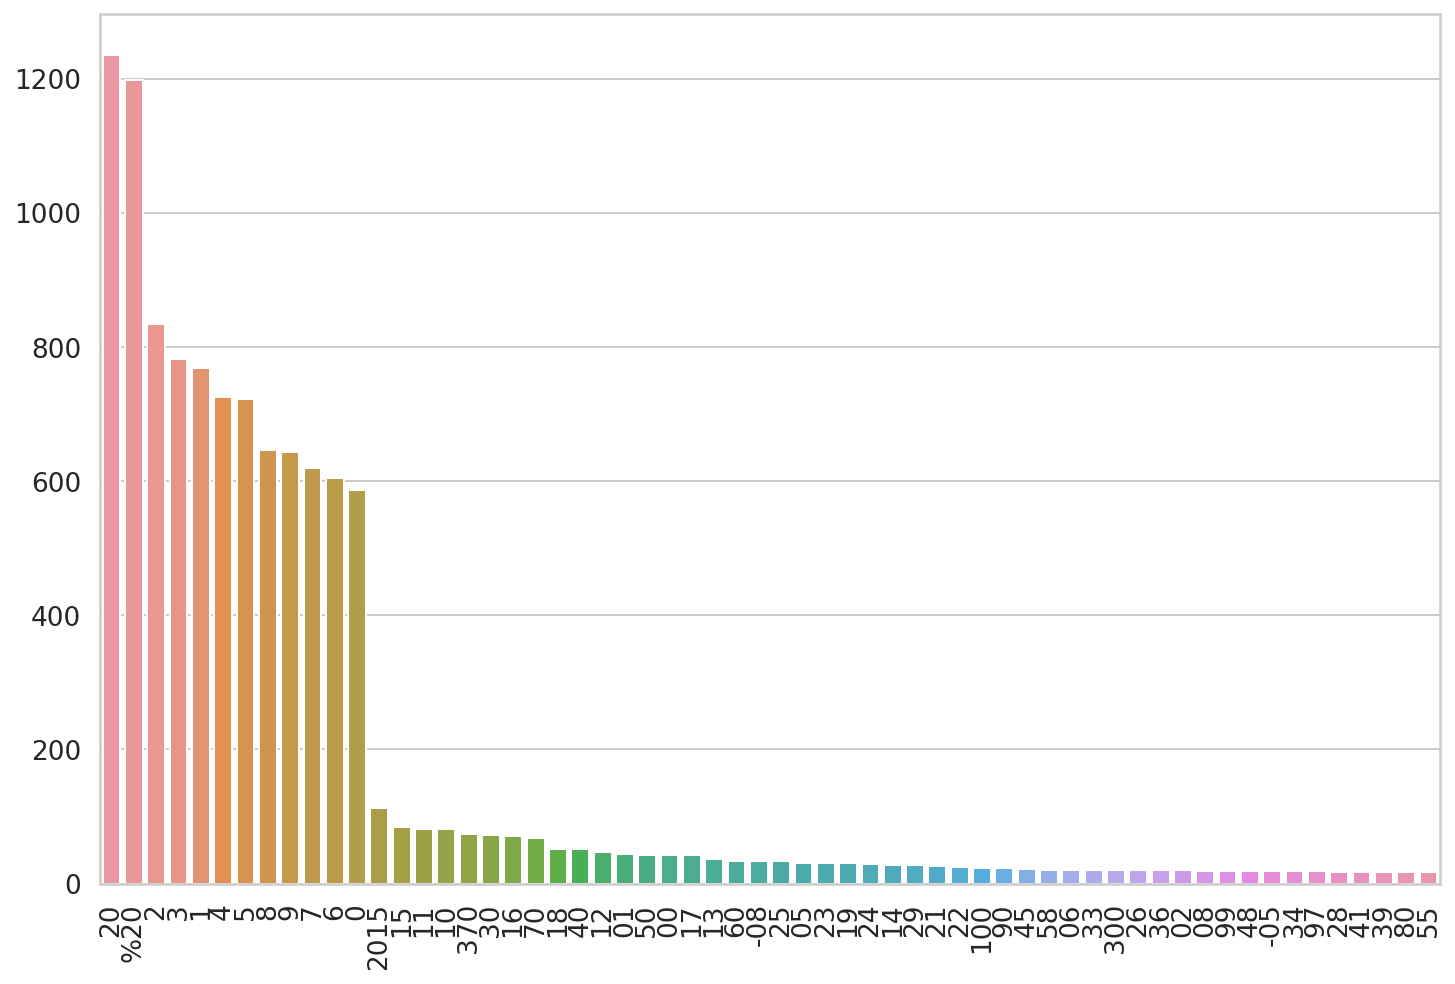

In [77]:
amount = 60
ax = sns.barplot(x = counts.head(amount).index, y = counts.head(amount).values)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Hay cierta tendencia por los numeros bajos

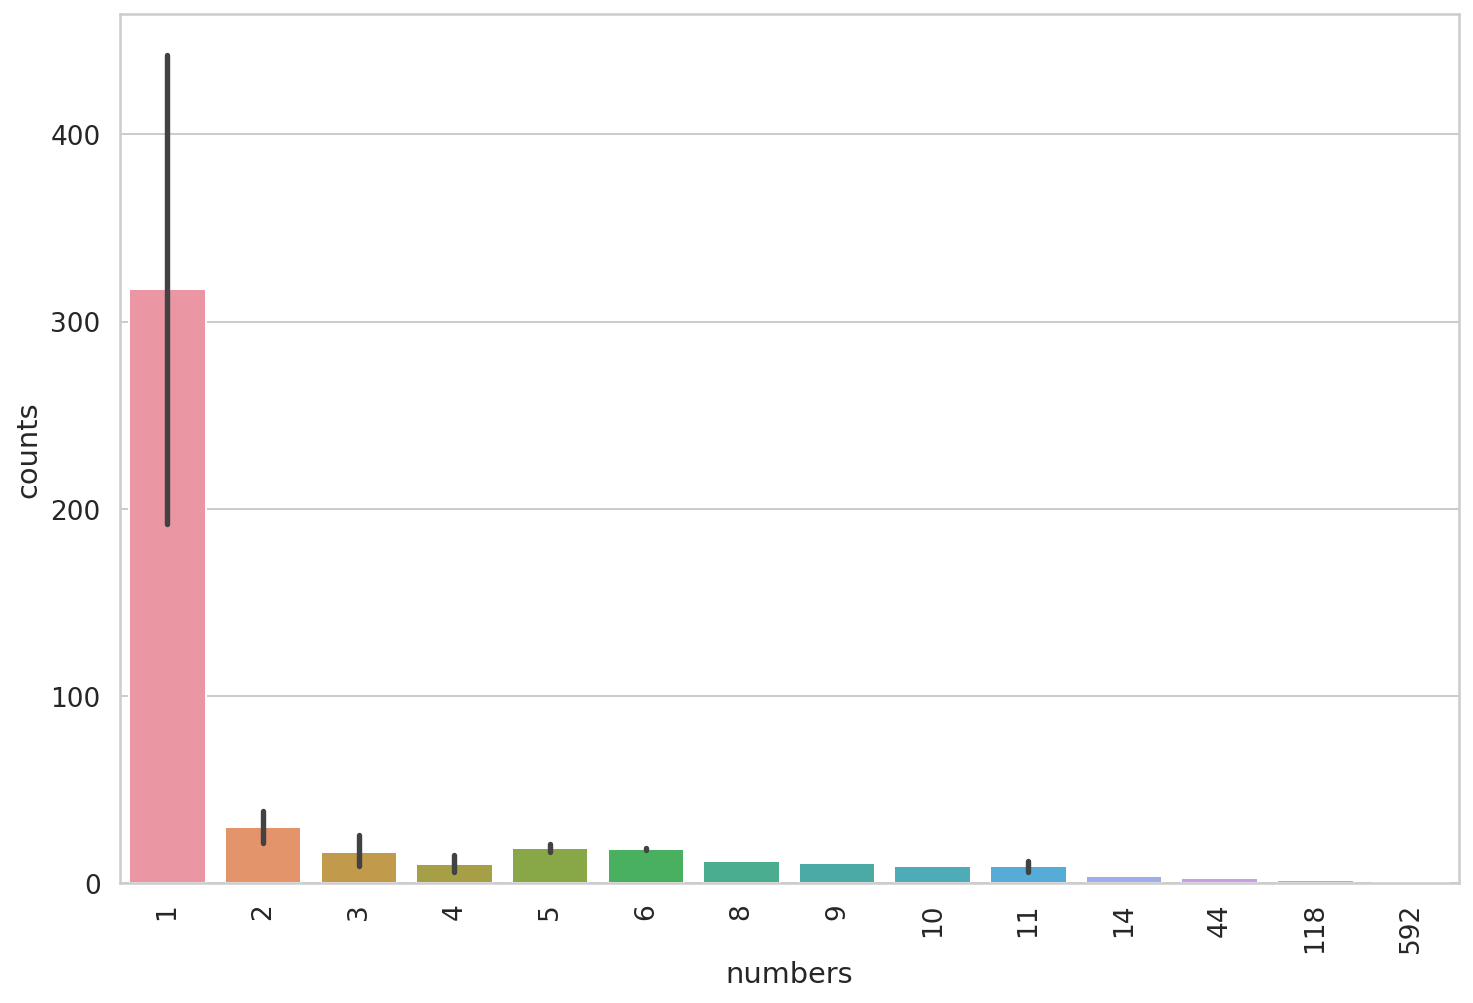

In [78]:
counts = numbers.value_counts().to_frame().reset_index()
counts.columns = ['numbers','counts']
counts_of_counts = counts.groupby('counts').count().reset_index()

ax = sns.barplot(x = counts_of_counts.numbers, y = counts_of_counts.counts)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

No confundir este grafico. El eje x no son numeros que pone la gente. Son cantidades de numeros que aparecen tantas veces.

Por ejemplo:

La primera barra arrancando desde la izquierda (la que dice 1 en x y 600 aprox en y) significa que hay 1 numero (no sabemos cual) que aparece alrededor de 600 veces.

La barra que tiene 2 en x y aprox 50 en y significa que hay 2 numeros que aparecen aprox 50 veces y asi...

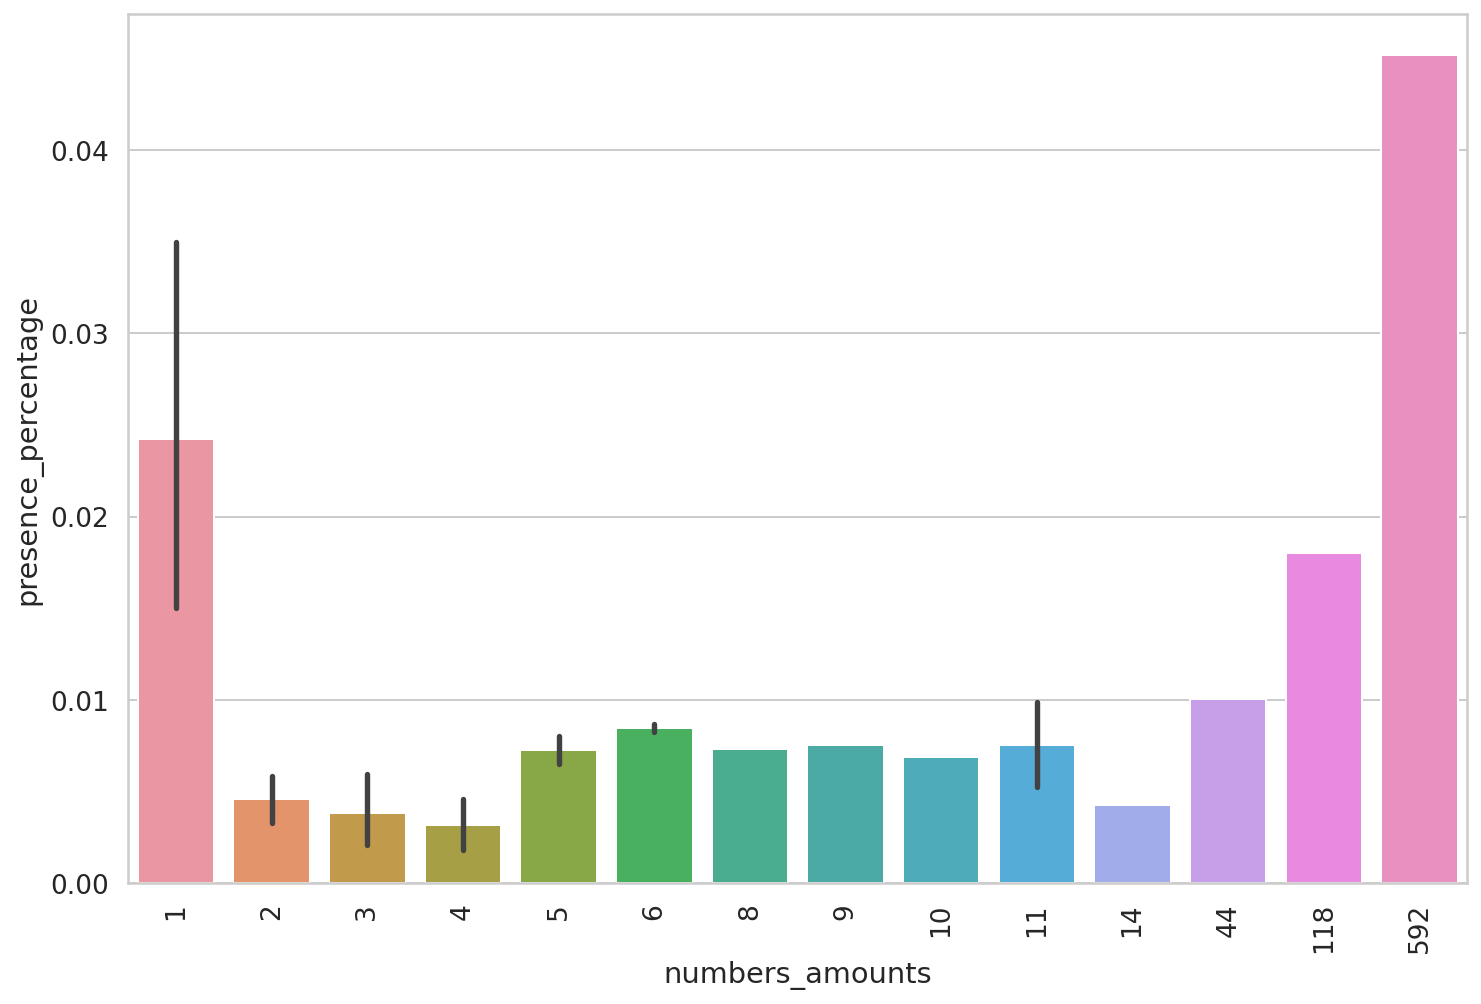

In [79]:
total_numbers = len(numbers)

counts_of_counts['presence_percentage'] = counts_of_counts.counts * counts_of_counts.numbers / total_numbers
counts_of_counts.columns = ['counts','numbers_amounts','presence_percentage']

ax = sns.barplot(x = counts_of_counts.numbers_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Vemos otra distribucion similar a la del tiempo y  fechas y a la de caracteres raros

In [80]:
counts_of_counts = counts_of_counts.sort_values('counts', ascending = False).reset_index()
counts_of_counts.head()

index  counts  numbers_amounts  presence_percentage
0     57    1235                1             0.094217
1     56    1198                1             0.091395
2     55     834                1             0.063625
3     54     782                1             0.059658
4     53     768                1             0.058590

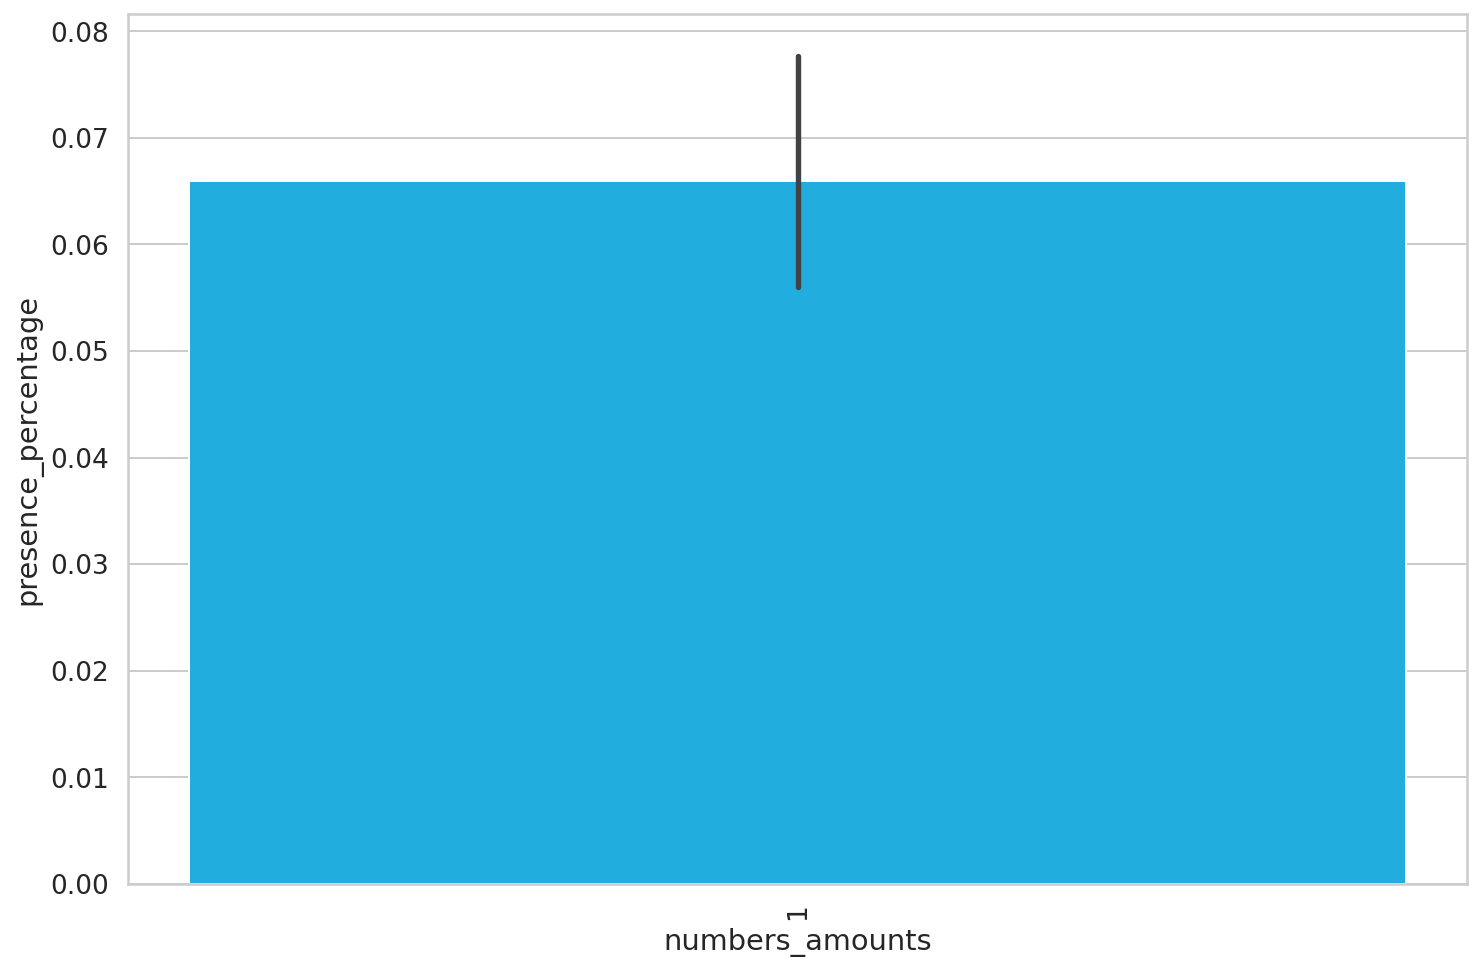

In [81]:
class_idx = 0
cumulated_prescence = 0
for idx,number_class in counts_of_counts.iterrows():
    cumulated_prescence += number_class.presence_percentage
    if cumulated_prescence >= 0.5:
        class_idx = idx
        break


to_filter_counts_of_counts = counts_of_counts.iloc[class_idx + 1:]
counts_of_counts = counts_of_counts.iloc[:class_idx + 1]
        
ax = sns.barplot(x = counts_of_counts.numbers_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [82]:
print("Cantidad de numeros que quedan: ",int(counts_of_counts.presence_percentage.sum() * total_numbers))
print("Cantidad de numeros que que habia: ",total_numbers)
print(f"Porcentaje filtrado por baja ocurrencia: {round(1 - counts_of_counts.presence_percentage.sum(),3)*100}%")

Cantidad de numeros que quedan:  6912
Cantidad de numeros que que habia:  13108
Porcentaje filtrado por baja ocurrencia: 47.3%


In [83]:
NUMBERS = ' NUMBERS '

to_filter_numbers = counts.merge(
        to_filter_counts_of_counts, on='counts'
).numbers.values

cleanNumbers = lambda x: NUMBERS if x.group(0) in to_filter_numbers else ' ' + x.group(0)

# Signos de Puntuacion que no son ? ni ! (esos los tratamos luego)

In [84]:
gramaticals_pattern = re.compile('[.,:;]')
gramaticals = pd.Series(re.findall(gramaticals_pattern,corpus))
gramaticals.value_counts()

.    12162
:     6966
,     1961
;      595
dtype: int64

No los tocamos porque BERT los usa

# Signos gramaticales no tan usados

In [85]:
punctuation_pattern = re.compile('&amp|[-_\\(\)\[\]\{\}|+=/*&]|%20|<|>')
punctuations = pd.Series(re.findall(punctuation_pattern,corpus))
punctuations.value_counts()

/       14801
-        1934
%20      1198
_         896
)         419
(         390
&amp      342
|         222
*         189
&         164
[         137
]         136
+          89
=          53
}           6
{           5
>           1
dtype: int64

In [86]:
print("Canitdad de puntuaciones en el corpus: ",len(punctuations))
print("Canitdad de puntuaciones unicos en el corpus: ",len(set(punctuations)))
counts = punctuations.value_counts()
counts

Canitdad de puntuaciones en el corpus:  20982
Canitdad de puntuaciones unicos en el corpus:  17


/       14801
-        1934
%20      1198
_         896
)         419
(         390
&amp      342
|         222
*         189
&         164
[         137
]         136
+          89
=          53
}           6
{           5
>           1
dtype: int64

Las puntuaciones esta ahi y son bastantes.

Para el caso del uso de BERT no vamos a removerlas ya que posee embeddings para estas.

https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/discussion/91972

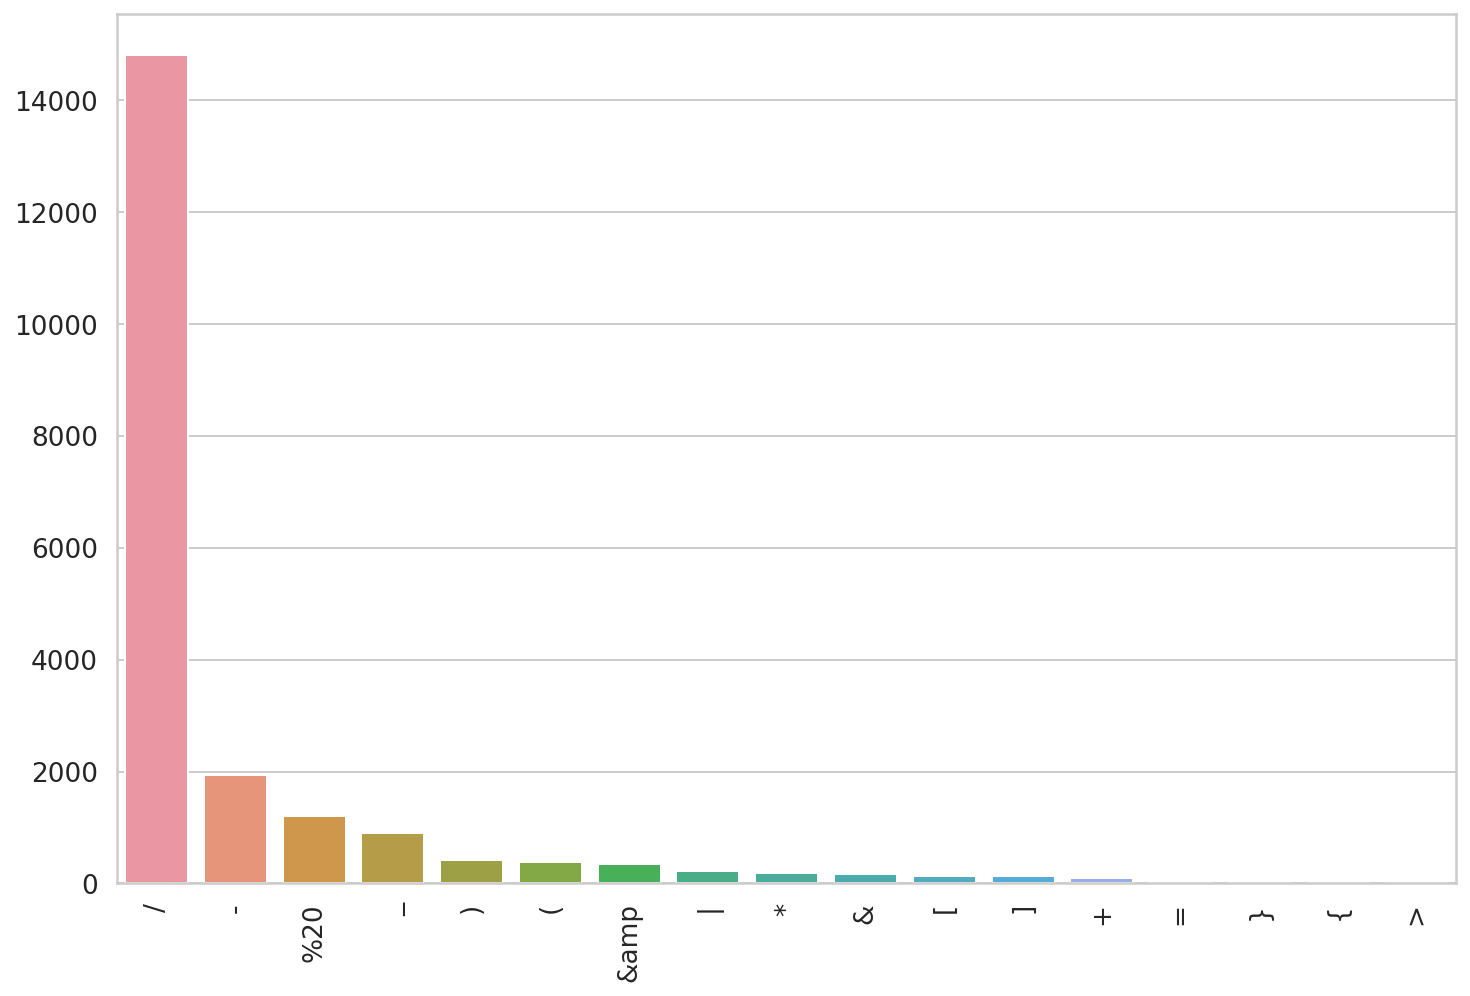

In [87]:
amount = 60
ax = sns.barplot(x = counts.head(amount).index, y = counts.head(amount).values)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

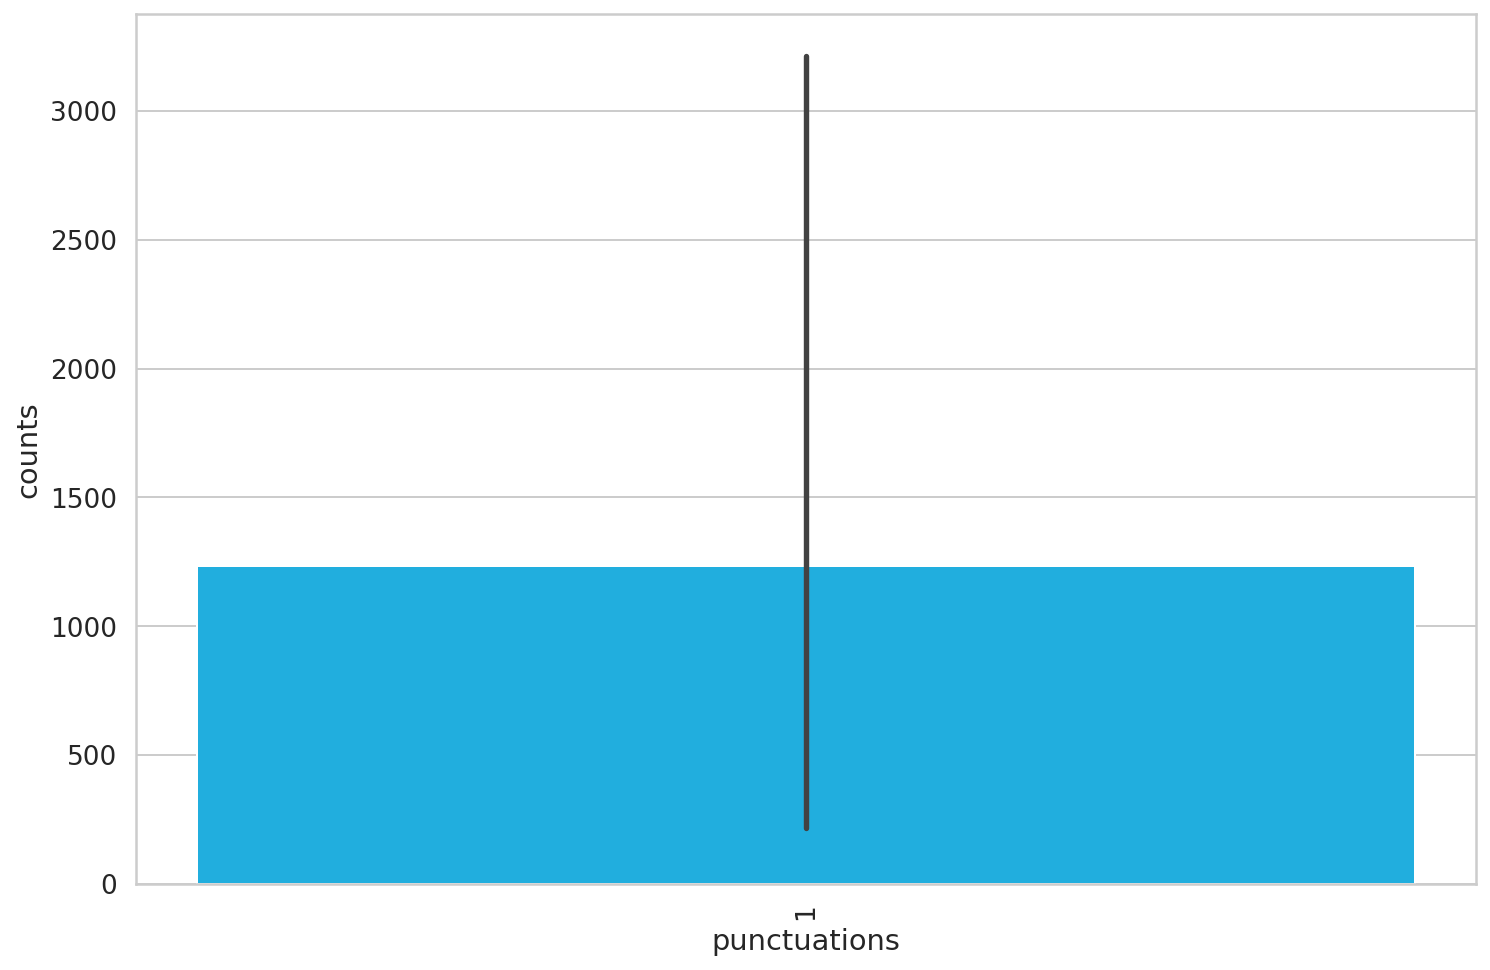

In [88]:
counts = punctuations.value_counts().to_frame().reset_index()
counts.columns = ['punctuations','counts']
counts_of_counts = counts.groupby('counts').count().reset_index()

ax = sns.barplot(x = counts_of_counts.punctuations, y = counts_of_counts.counts)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

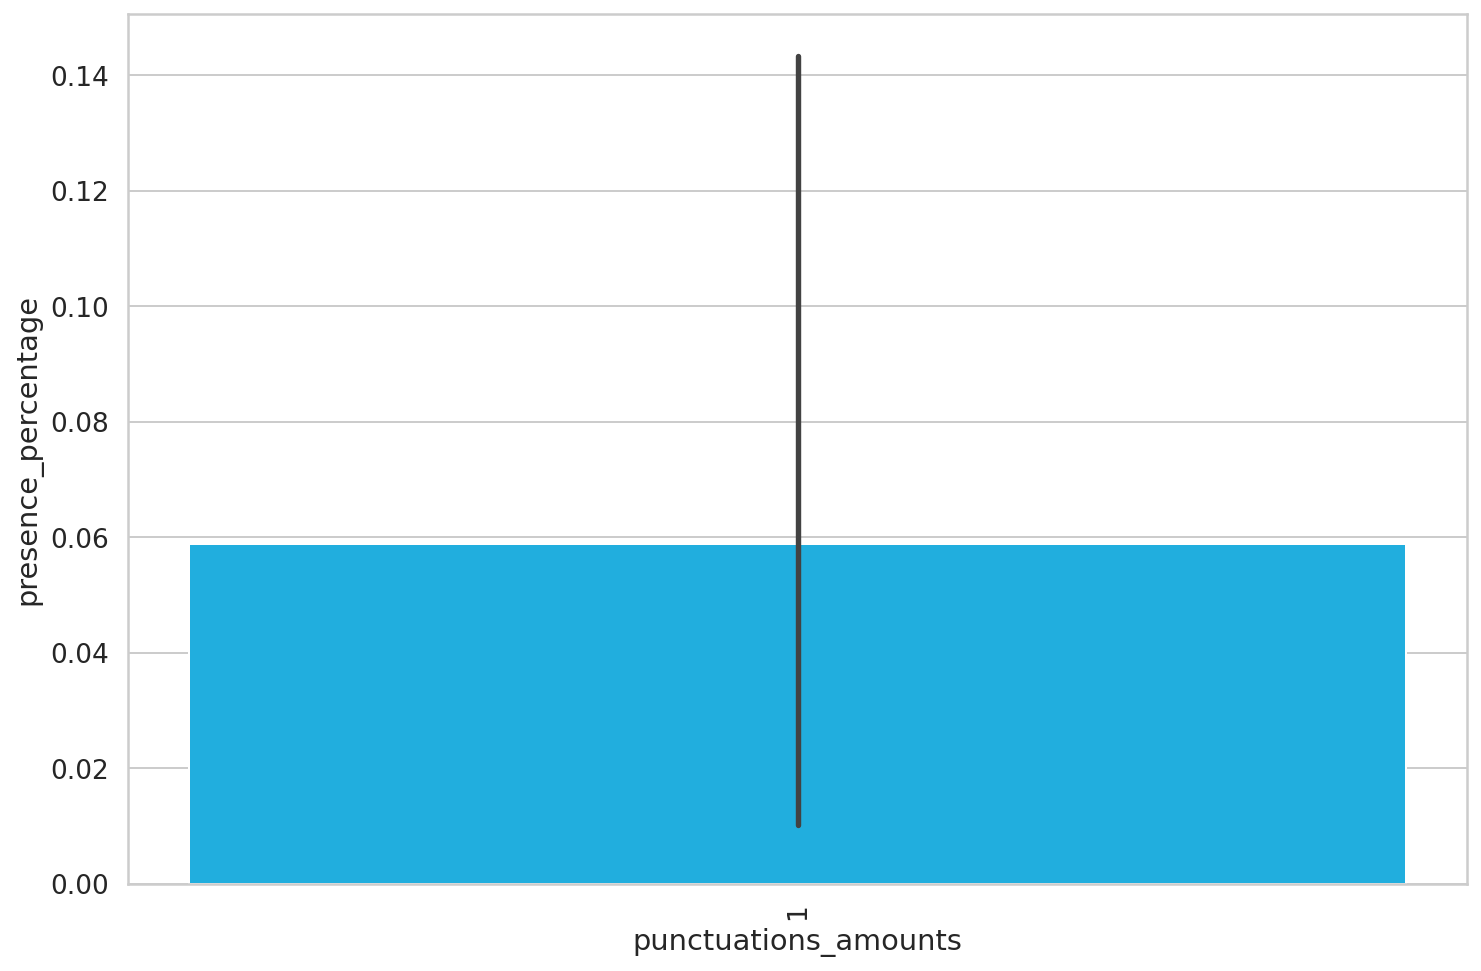

In [89]:
total_punctuations = len(punctuations)

counts_of_counts['presence_percentage'] = counts_of_counts.counts * counts_of_counts.punctuations / total_punctuations
counts_of_counts.columns = ['counts','punctuations_amounts','presence_percentage']

ax = sns.barplot(x = counts_of_counts.punctuations_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [90]:
counts_of_counts = counts_of_counts.sort_values('counts', ascending = False).reset_index()
counts_of_counts.head()

index  counts  punctuations_amounts  presence_percentage
0     16   14801                     1             0.705414
1     15    1934                     1             0.092174
2     14    1198                     1             0.057097
3     13     896                     1             0.042703
4     12     419                     1             0.019969

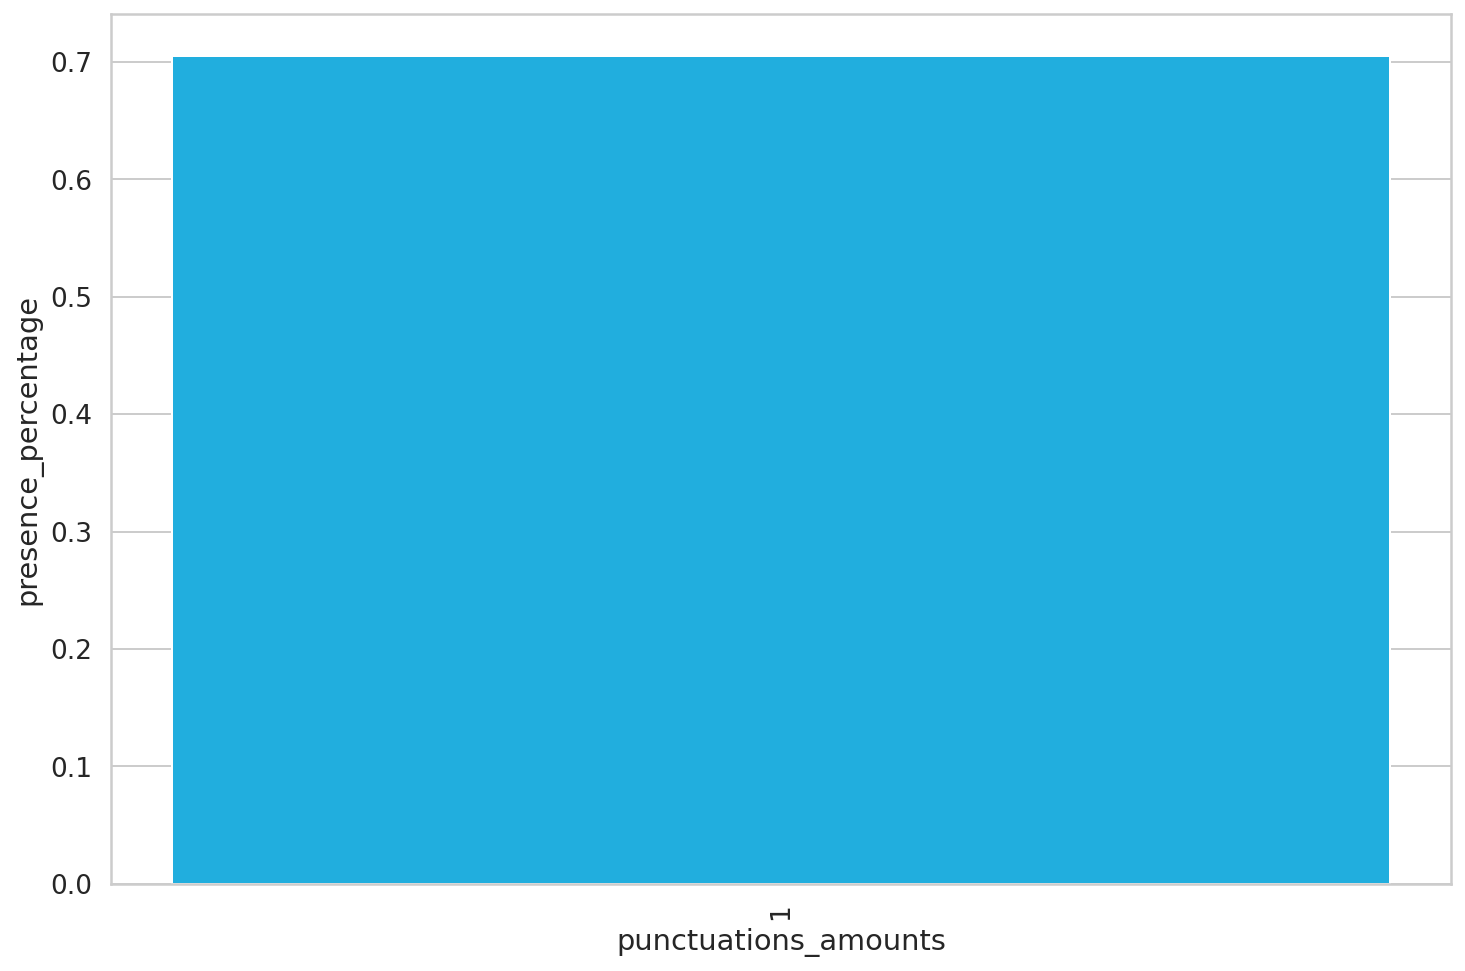

In [91]:
class_idx = 0
cumulated_prescence = 0
for idx,punctiation_class in counts_of_counts.iterrows():
    cumulated_prescence += punctiation_class.presence_percentage
    if cumulated_prescence >= 0.5:
        class_idx = idx
        break


to_filter_counts_of_counts = counts_of_counts.iloc[class_idx + 1:]
counts_of_counts = counts_of_counts.iloc[:class_idx + 1]
        
ax = sns.barplot(x = counts_of_counts.punctuations_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [92]:
print("Cantidad de puntuaciones que quedan: ",counts_of_counts.presence_percentage.sum() * total_punctuations)
print("Cantidad de puntuaciones que que habia: ",total_punctuations)
print(f"Porcentaje filtrado por baja ocurrencia: {round(1 - counts_of_counts.presence_percentage.sum(),3)*100}%")

Cantidad de puntuaciones que quedan:  14801.0
Cantidad de puntuaciones que que habia:  20982
Porcentaje filtrado por baja ocurrencia: 29.5%


In [93]:
PUNCTUATION = ' PUNCTUATION '

to_filter_punctuations = counts.merge(
        to_filter_counts_of_counts, on='counts'
).punctuations.values

cleanPunctuations = lambda x: PUNCTUATION if x.group(0) in to_filter_punctuations else ' ' + x.group(0) #Se separan las puntuaciones

#Signos de ? y !

Queremos que cosas como !!! se mapeen a ! ! ! para que el tokenizador identique que hay 3 '!' y no 1 '!!!'

In [94]:
excl_interr_pattern = re.compile('(?:[a-zA-Z0-9]+|\s)([!?]+)') #no tomar el hashtag '#???'
excl_interr = pd.Series(re.findall(excl_interr_pattern,corpus))
excl_interr

0            ?
1       !!!!!!
2            !
3            !
4            ?
         ...  
2268         !
2269         !
2270         ?
2271        ??
2272        ??
Length: 2273, dtype: object

In [95]:
cleanExclInterr = lambda x: x.group(0).replace(x.group(1),'') + ' ' + ' '.join([c for c in x.group(1)]) + ' '

# Analizando el campo de keywords

In [96]:
keywords_corpus = ' '.join(data.keyword)

In [97]:
keywords_corpus

'                                                              ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze ablaze accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident accident aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftershock aftersh

Una inspeccion revela que el campo keyword esta realmente muy limpio (salvo los %20 que ya nos ocupamos)

# Analizando el campo locations

In [98]:
location_corpus = ' '.join(data.location)

In [99]:
location_corpus

"                                                              Birmingham Est. September 2012 - Bristol AFRICA Philadelphia, PA London, UK Pretoria World Wide!!   Paranaque City Live On Webcam   milky way       GREENSBORO,NORTH CAROLINA   Live On Webcam England. Sheffield Township, Ohio India Barbados Anaheim Abuja USA South Africa Sao Paulo, Brazil hollywoodland  Edmonton, Alberta - Treaty 6   Inang Pamantasan Twitter Lockout in progress Concord, CA Calgary, AB Birmingham San Francisco CLVLND Nashville, TN Santa Clara, CA UK St. Louis, MO Walker County, Alabama Australia North Carolina   Norf Carolina San Mateo County, CA North Carolina Njoro, Kenya   Your Sister's Bedroom   Arlington, TX South Bloomfield, OH   New Hanover County, NC Maldives Manchester, NH Wilmington, NC   New Hanover County, NC   global Alberta | Sask. | Montana Charlotte Baton Rouge, LA Hagerstown, MD Gloucestershire , UK   UK Nairobi, Kenya Instagram - @heyimginog  304 Switzerland 304 US 304 Instagram - @heyimgino

En location la gente se pone mas creativa....

Aplicamos los filtros que desarrollamos hasta ahora

In [100]:

corpus2 = re.sub(hashtag_pattern,cleanHashtags,location_corpus)
corpus2 = re.sub(mentions_pattern,cleanMentions,corpus2)
corpus2 = re.sub(links_pattern,cleanLinks,corpus2)
corpus2 = re.sub(html_pattern,cleanHTMLS,corpus2)
corpus2 = re.sub(emoji_pattern,cleanEmojis,corpus2)
corpus2 = re.sub(mails_pattern,cleanMails,corpus2)
corpus2 = re.sub(times_pattern_1,cleanTimes,corpus2)
corpus2 = re.sub(times_pattern_2,cleanTimes,corpus2)
corpus2 = re.sub(times_pattern_3,cleanTimes,corpus2)
corpus2 = re.sub(times_pattern_4,cleanTimes,corpus2)
corpus2 = re.sub(weird_pattern,cleanWeirds,corpus2)
corpus2 = re.sub(numeric_pattern,cleanNumericPattern,corpus2)
corpus2 = re.sub(money_pattern,cleanMoney,corpus2)
corpus2 = re.sub(punctuation_pattern,cleanPunctuations,corpus2)
corpus2 = re.sub(number_pattern,cleanNumbers,corpus2)
corpus2 = re.sub(excl_interr_pattern,cleanExclInterr,corpus2)


In [101]:
corpus2

"                                                               Birmingham Est. September  TIME   PUNCTUATION  Bristol AFRICA Philadelphia, PA London, UK Pretoria World Wide ! !    Paranaque City Live On Webcam   milky way       GREENSBORO,NORTH CAROLINA   Live On Webcam England. Sheffield Township, Ohio India Barbados Anaheim Abuja USA South Africa Sao Paulo, Brazil hollywoodland  Edmonton, Alberta  PUNCTUATION  Treaty  NUMBERS    Inang Pamantasan Twitter Lockout in progress Concord, CA Calgary, AB Birmingham San Francisco CLVLND Nashville, TN Santa Clara, CA UK St. Louis, MO Walker County, Alabama Australia North Carolina   Norf Carolina San Mateo County, CA North Carolina Njoro, Kenya   Your Sister's Bedroom   Arlington, TX South Bloomfield, OH   New Hanover County, NC Maldives Manchester, NH Wilmington, NC   New Hanover County, NC   global Alberta  PUNCTUATION  Sask.  PUNCTUATION  Montana Charlotte Baton Rouge, LA Hagerstown, MD Gloucestershire , UK   UK Nairobi, Kenya Instagram  P

Realmente el texto queda mas limpio

# Tratamiento de Lugares, Nombres y Acronimos

Ahora se va a analizar que "lugares" son mas frecuentes, cuantos hay y que filtrar.

Decimos "lugar" porque la gente pone de todo y tranquilamente podriamos detectar 'The Greatest Country Ever' como una location.

No tenemos forma de validar si eso es un pais o no sin tener un diccionario (que tenemos, pero no anda bien).

Estos casos no nos importan. Si es un pais real o si la gente se refiere a el como pseudonimo entonces va a tener mucha frecuencia. Esto es lo que vamos a usar.

Lo mismo hacemos con nombres y acronimos.

In [102]:
name_pattern = re.compile('(([\w*\.?]*[A-Z]+[\w*\.?]*\s+[\w*\.?]*[A-Z]+[\w*\.?]*|[\w*\.?]*[A-Z]+[\w*\.?]*)+)')
names = pd.Series([n[0] for n in re.findall(name_pattern,corpus)])

In [103]:
print("Canitdad de nombres en el corpus: ",len(names))
print("Canitdad de nombres unicos en el corpus: ",len(set(names)))
counts = names.value_counts()
counts

Canitdad de nombres en el corpus:  35383
Canitdad de nombres unicos en el corpus:  19226


I             1310
The            222
USA            181
A              156
CA             139
              ... 
Dominicana       1
I2C00FcOwb       1
Ridge            1
LoveFood         1
he7Q7H3nZf       1
Length: 19226, dtype: int64

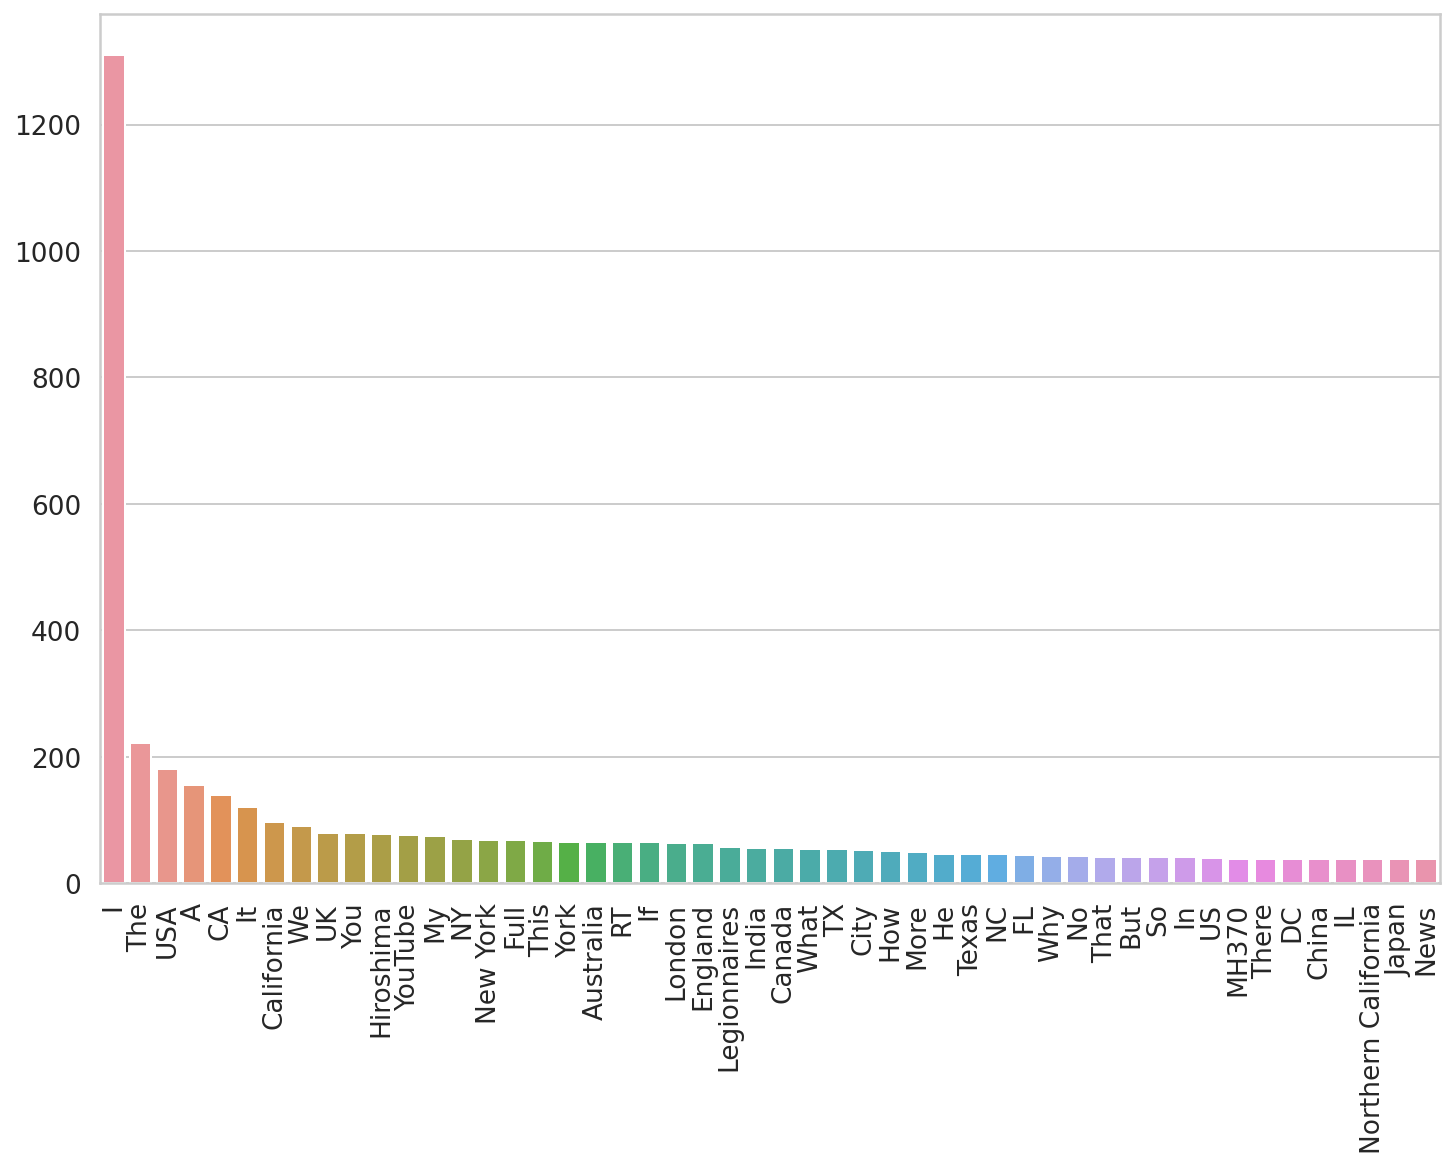

In [104]:
amount = 50
ax = sns.barplot(x = counts.head(amount).index, y = counts.head(amount).values)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Vemos muchas stopwords aca. 

Queremos dejar en claro que estaria MAL quitar las stopwords si pretendemos darle este texto a BERT debido a que BERT aprendio a manejarlas y funciona mejor con ellas.

Dicho esto vamos a quitar las stopwords SOLO de es esta seccion para que el filtrado de nombres sea justo.

Es interesante como dato de color ver que 'I' es mas frecuente que 'The' y que cualquier otro nombre. Mucha gente hablando de uno.

In [105]:
names = pd.Series([n for n in list(names.values) if not n.lower() in stops])
print("Canitdad de nombres en el corpus: ",len(names))
print("Canitdad de nombres unicos en el corpus: ",len(set(names)))
counts = names.value_counts()
counts

Canitdad de nombres en el corpus:  31662
Canitdad de nombres unicos en el corpus:  19064


USA                181
CA                 139
California          97
UK                  80
Hiroshima           78
                  ... 
Trillion Dollar      1
mmGsyAHDzb           1
Stonewall            1
NickLee8             1
New Caesars          1
Length: 19064, dtype: int64

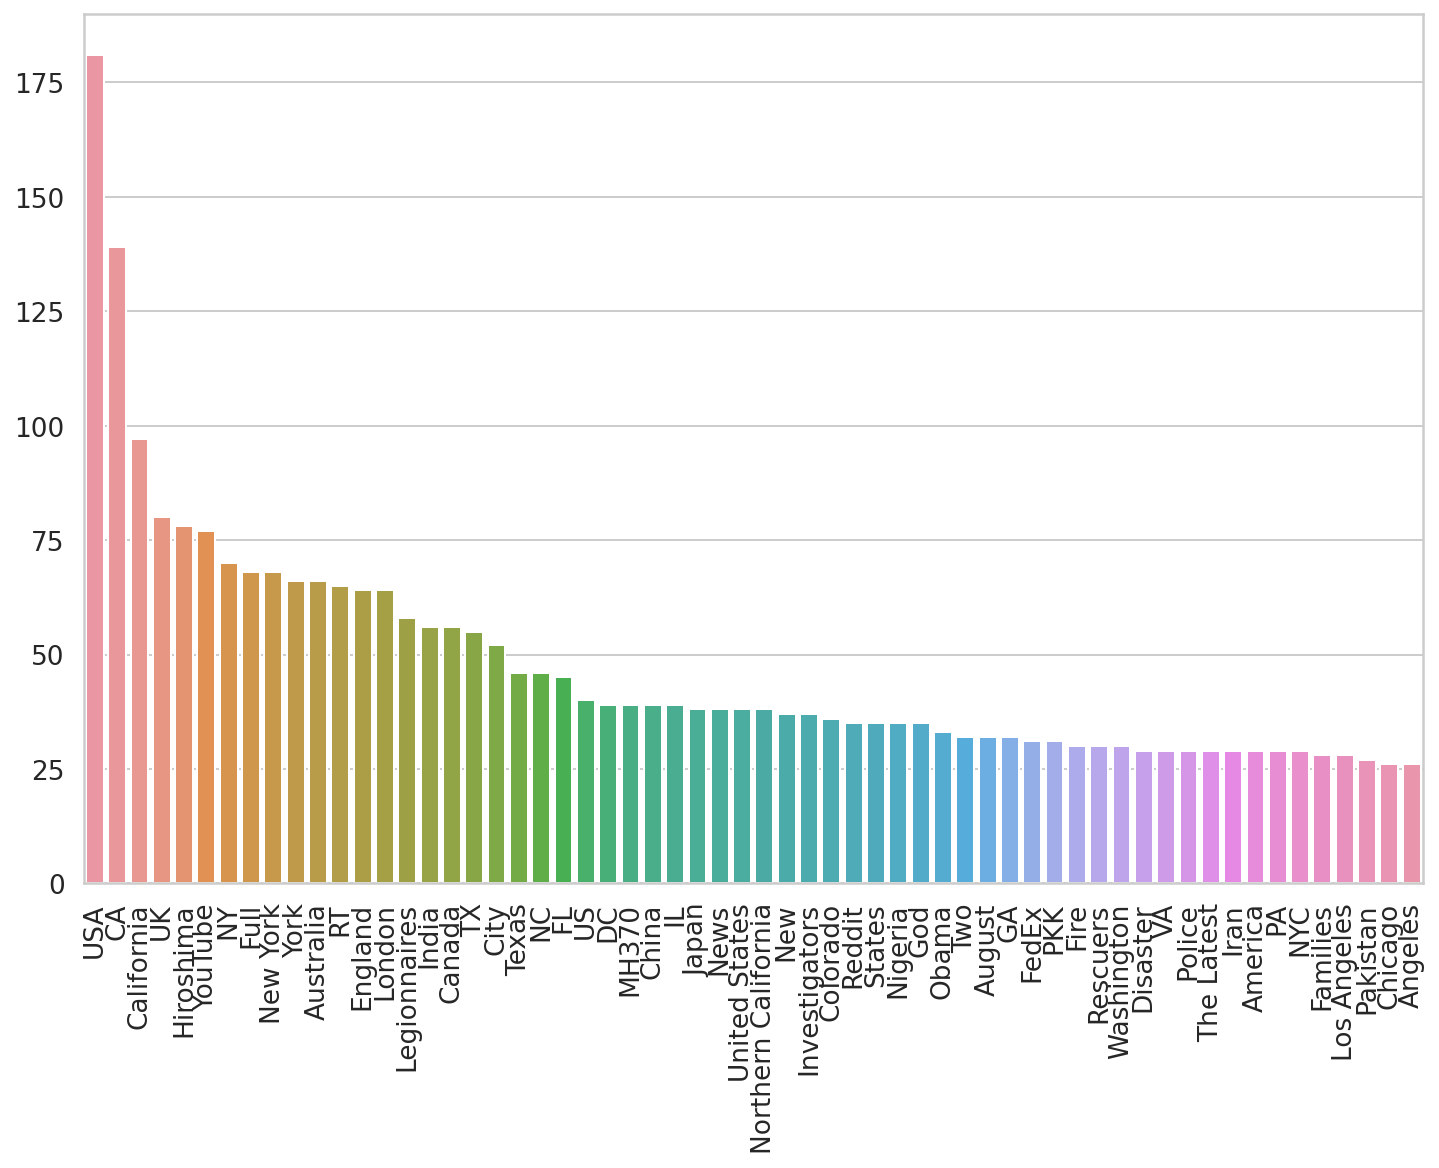

In [106]:
amount = 60
ax = sns.barplot(x = counts.head(amount).index, y = counts.head(amount).values)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

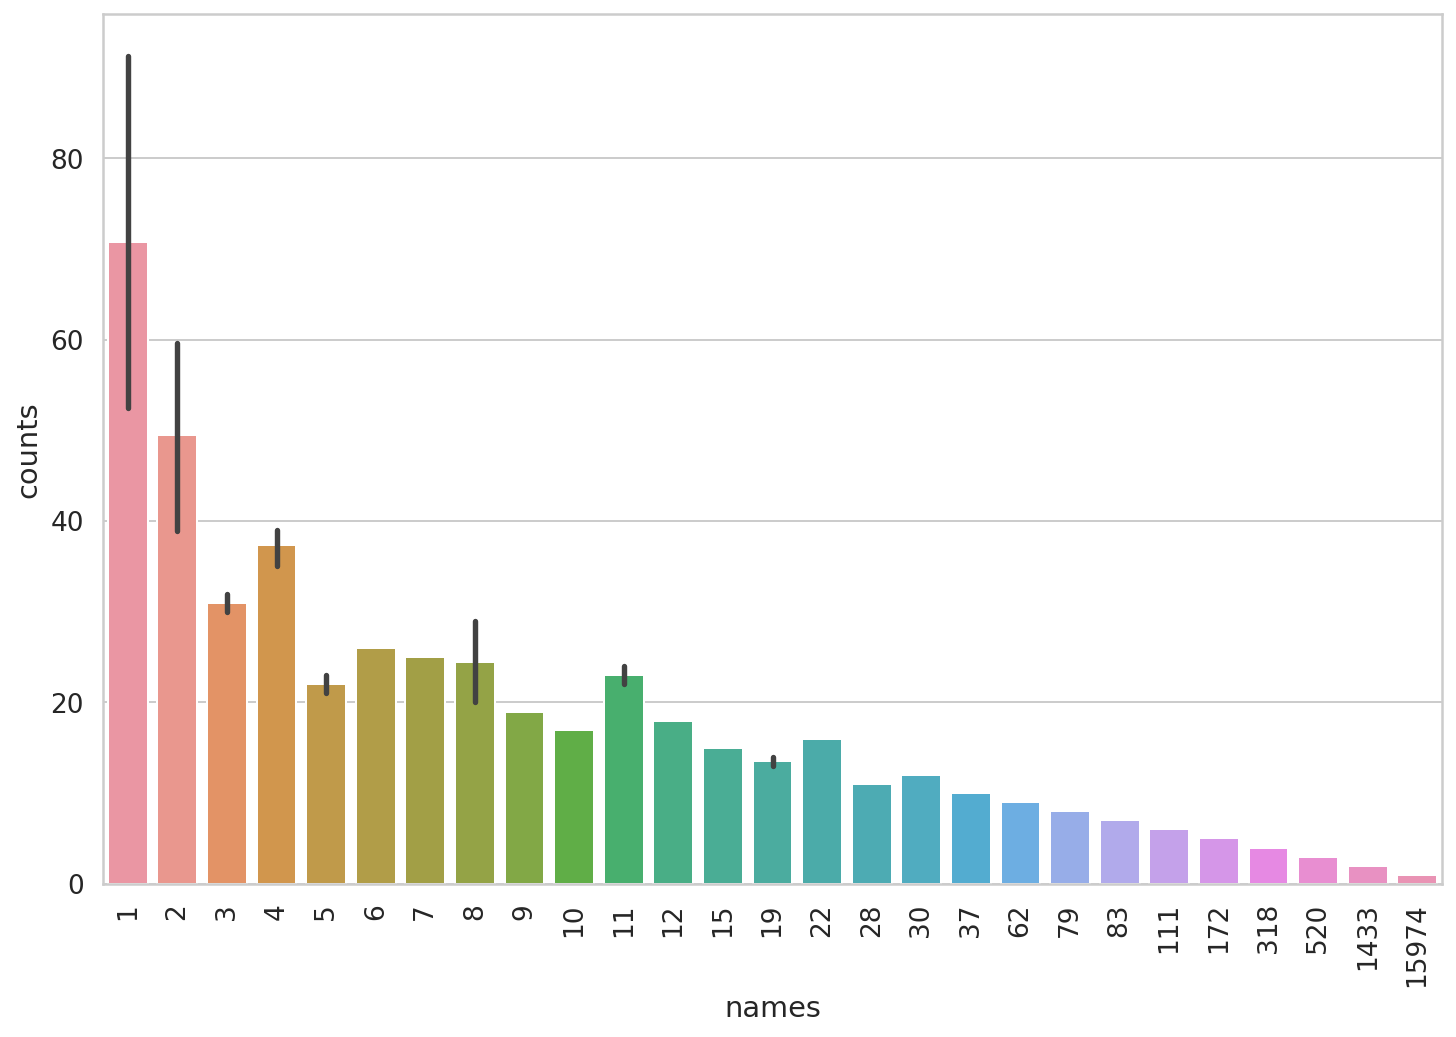

In [107]:
counts = names.value_counts().to_frame().reset_index()
counts.columns = ['names','counts']
counts_of_counts = counts.groupby('counts').count().reset_index()

ax = sns.barplot(x = counts_of_counts.names, y = counts_of_counts.counts)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

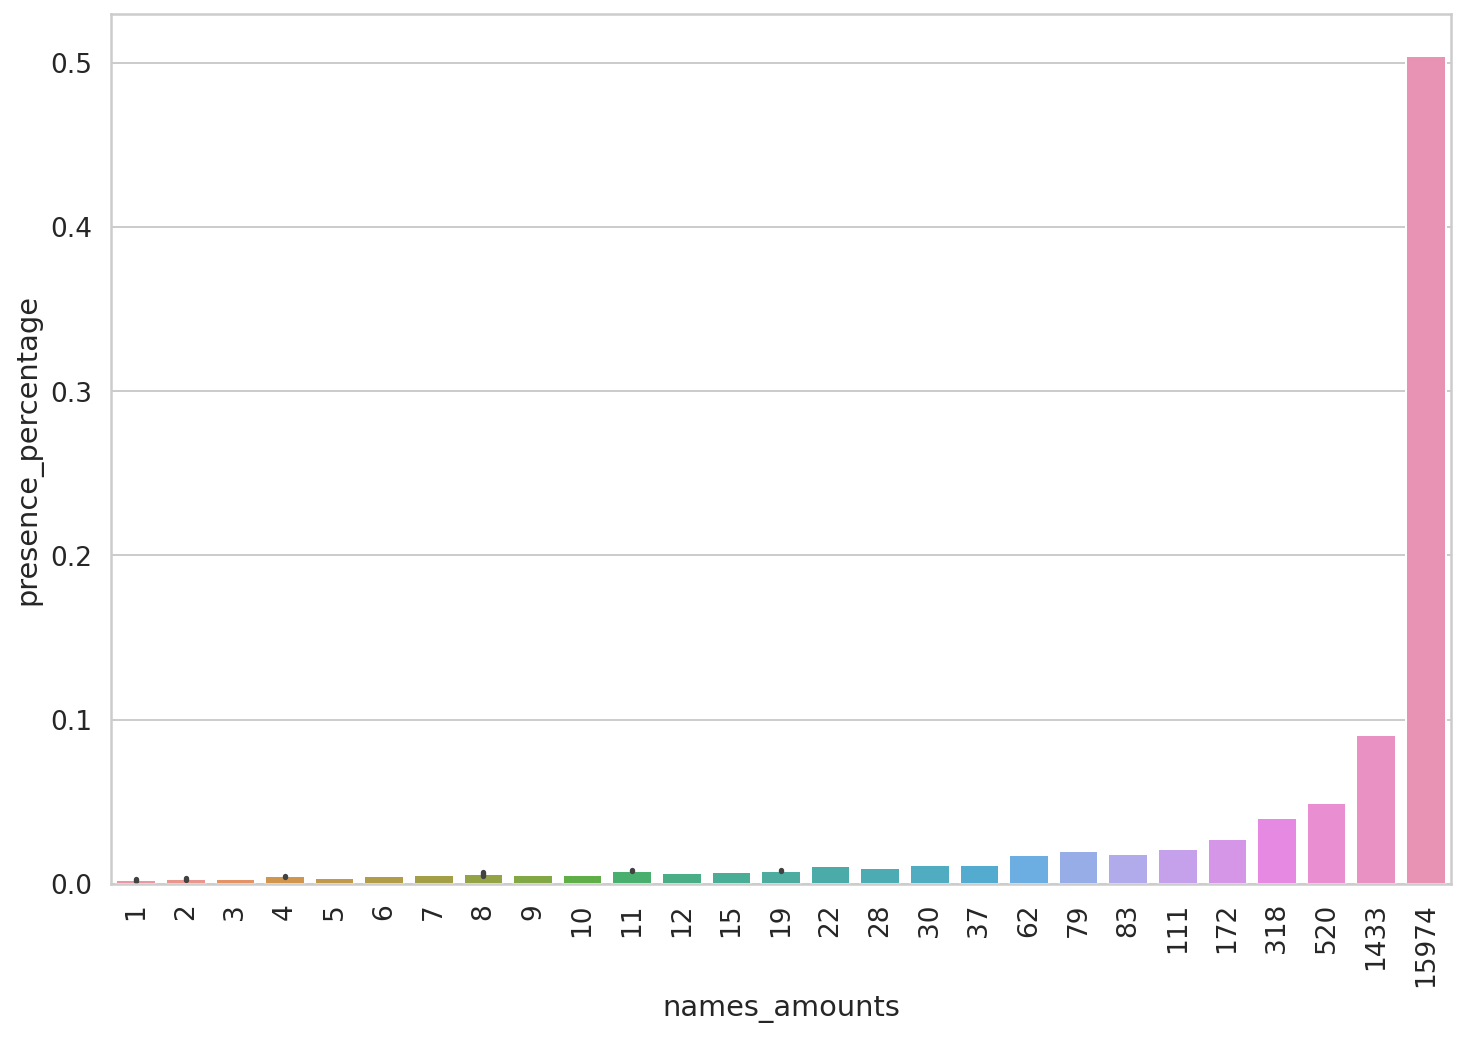

In [108]:
total_names = len(names)

counts_of_counts['presence_percentage'] = counts_of_counts.counts * counts_of_counts.names / total_names
counts_of_counts.columns = ['counts','names_amounts','presence_percentage']

ax = sns.barplot(x = counts_of_counts.names_amounts, y = counts_of_counts.presence_percentage)
v = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Otra cosa interesante. De los nombres que se usan hay una power law. Hay mas nombres que se usan poco (por mucho) que nombres que se usan mucho.

In [109]:
counts_of_counts = counts_of_counts.sort_values('counts', ascending = False).reset_index()
counts_of_counts.tail()

index  counts  names_amounts  presence_percentage
51      4       5            172             0.027162
52      3       4            318             0.040174
53      2       3            520             0.049270
54      1       2           1433             0.090519
55      0       1          15974             0.504516

Aca podemos ver algo interesante. La clase de los nombres que solo figuran una vez tiene una presencia del 50.4%. 

Esto siginifica que ni todas las otras sumadas la superan. Como no queremos quedarnos con todos los nombres filtramos a mano esta ultima clase.

In [110]:
to_filter_counts_of_counts = counts_of_counts.tail(1)
counts_of_counts = counts_of_counts.iloc[:-1]

Nombres no filtrados

In [111]:
counts.merge(
        counts_of_counts, on='counts'
).head()

names  counts  index  names_amounts  presence_percentage
0         USA     181     55              1             0.005717
1          CA     139     54              1             0.004390
2  California      97     53              1             0.003064
3          UK      80     52              1             0.002527
4   Hiroshima      78     51              1             0.002464

In [112]:
print("Cantidad de nombres que quedan: ",counts_of_counts.presence_percentage.sum() * total_names)
print("Cantidad de nombres que que habia: ",total_names)
print(f"Porcentaje filtrado por baja ocurrencia: {round(1 - counts_of_counts.presence_percentage.sum(),3)*100}%")

Cantidad de nombres que quedan:  15688.0
Cantidad de nombres que que habia:  31662
Porcentaje filtrado por baja ocurrencia: 50.5%


In [113]:
NAME = ' NAME '

to_filter_names = counts.merge(
        to_filter_counts_of_counts, on='counts'
).names.values

cleanNames = lambda x: NAME if x.group(0) in to_filter_names else ' ' + x.group(0)

# Limpiamos para la siguiente etapa

In [114]:
corpus = re.sub(hashtag_pattern,cleanHashtags,corpus)
corpus = re.sub(mentions_pattern,cleanMentions,corpus)
corpus = re.sub(links_pattern,cleanLinks,corpus)
corpus = re.sub(html_pattern,cleanHTMLS,corpus)
corpus = re.sub(emoji_pattern,cleanEmojis,corpus)
corpus = re.sub(mails_pattern,cleanMails,corpus)
corpus = re.sub(times_pattern_1,cleanTimes,corpus)
corpus = re.sub(times_pattern_2,cleanTimes,corpus)
corpus = re.sub(times_pattern_3,cleanTimes,corpus)
corpus = re.sub(times_pattern_4,cleanTimes,corpus)
corpus = re.sub(weird_pattern,cleanWeirds,corpus)
corpus = re.sub(numeric_pattern,cleanNumericPattern,corpus)
corpus = re.sub(money_pattern,cleanMoney,corpus)
corpus = re.sub(punctuation_pattern,cleanPunctuations,corpus)
corpus = re.sub(number_pattern,cleanNumbers,corpus)
corpus = re.sub(excl_interr_pattern,cleanExclInterr,corpus)
corpus = re.sub(name_pattern,cleanNames,corpus)

# Ultima inspeccion en busca de mas patrones anomalos

In [115]:
corpus

"      NAME  are the  Reason of this  #earthquake  NAME   NAME  us all      Forest fire near  NAME   NAME       All residents asked to 'shelter in place' are being notified by officers.  No other evacuation or shelter in place orders are expected       NUMBERS ,  NUMBERS  people receive  #wildfires evacuation orders in  NAME  got sent this photo from  NAME   # Alaska as smoke from  #wildfires pours into a school       # NAME    PUNCTUATION  PUNCTUATION   NAME   20 closed in both directions due to  NAME  fire   PUNCTUATION   HASHTAG   #wildfires      #flood  #disaster  Heavy rain causes flash flooding of streets in  NAME ,  Colorado Springs areas      I'm on top of the hill and  I can see a fire in the woods...      There's an emergency evacuation happening now in the building across the street      I'm afraid that the tornado is coming to our area...      Three people died from the heat wave so far      NAME   Tampa is getting flooded hah  PUNCTUATION  WAIT  A SECOND  I LIVE  IN SOUTH 

# Buscando 1-gramas, 2-gramas y 3-gramas

In [116]:
one_grams = corpus.split()
two_grams = [(w,one_grams[i+1]) for i,w in enumerate(one_grams) if (i < len(one_grams) - 1)]
three_grams = [(w,one_grams[i+1],one_grams[i+2]) for i,w in enumerate(one_grams) if (i < len(one_grams) - 2)]

In [117]:
one_grams = pd.Series(one_grams)
two_grams = pd.Series(two_grams)
three_grams = pd.Series(three_grams)

In [118]:
one_grams.value_counts().head(20)/len(one_grams)*100

NAME           5.066557
PUNCTUATION    3.880198
LINK           3.246192
?              2.414574
the            1.836833
WEIRD          1.705091
MENTION        1.504734
NUMBERS        1.387402
a              1.301633
to             1.255661
in             1.247427
of             1.237135
HASHTAG        1.174009
and            0.921504
!              0.817895
I              0.817209
#              0.716344
on             0.572938
for            0.570193
is             0.564704
dtype: float64

In [119]:
tags = ' '.join([HASHTAG, MENTION, LINK, HTML, EMOJI, MAIL,
        TIME, WEIRD, NUMERIC_PATTERN, MONEY, NUMBERS,
        PUNCTUATION, NAME])

tokens = pd.DataFrame({
    'content':one_grams,
})
tokens['isTag'] = tokens.content.apply(lambda x: x in tags)

print(f"Porcentaje de tags en corpus: {round(tokens.isTag.sum()/len(tokens),3)*100}%")

Porcentaje de tags en corpus: 19.6%


Un quinto de todos los tokens del corpus es un tag nuestro. 

Esto podria ser malo si hicimos mal el trabajo de tageo ya que estariamos tirando a la basura informacion util.

Ahora, si hicimos bien el trabajo de tageo entonces esto es muy bueno porque significa que al menos un quinto del set de datos era ruido que eliminamos.

# Generando train y test limpios

Terminamos la tarea de limpieza. Lo que generamos a ahora es un train y test que BERT y cualquier red neuronal sera capaz de aprovechar al maximo (en particular las preentrenadas)

Para los arboles de decision, que manejan data estructurada, (como XGBoost), la cosa de valor producida es este notebook mismo. El analisis aca expuesto es capaz de extraer algunos features bastante utiles.

Estos features sera recolectados junto con otros (como longitud de palabras, cantidad de palabras, cantidad de caracteres, cantidad de numero, cantidad de mayusuculas y minusculas, etc) mas adelante.

En lo que sigue se busca generalizar todo este analisis hecho para que pueda extenderse al set de test sin 'overfitear la limpieza de datos' (sin usar patrones nativos del set de train para filtrar el de test)

Por ejemplo, si en el analisis de hashtags aplicasemos exactamente el mismo filtro que en train estariamos diciendo que test no debe contemplar los hashtags menos frecuentes de train. 

El problema con esto es que los hashtags menos frecuentes de train, al ser los menos frecuentes, es probable que figuren poco tambien en el de test o que no figuren en absoluto en el de test. Esto resulta en un filtro inutil.

Siguiendo con el ejemplo, lo que hariamos seria tomar como hashtags a filtrar los menos frecuentes pero de test. A esto nos referimos con generalizar el analisis.

In [120]:
def generate_to_filter_list(features, last=False):

    counts = features.value_counts().to_frame().reset_index()
    counts.columns = ['features','counts']
    counts_of_counts = counts.groupby('counts').count().reset_index()
    total_features = len(features)
    counts_of_counts['presence_percentage'] = counts_of_counts.counts * counts_of_counts.features / total_features
    counts_of_counts.columns = ['counts','features_amounts','presence_percentage']
    counts_of_counts = counts_of_counts.sort_values('counts', ascending = False).reset_index()

    if last:
        to_filter_counts_of_counts = counts_of_counts.tail(1)

    else:
        class_idx = 0
        cumulated_prescence = 0
        for idx,features_class in counts_of_counts.iterrows():
            cumulated_prescence += features_class.presence_percentage
            if cumulated_prescence >= 0.5:
                class_idx = idx
                break
        to_filter_counts_of_counts = counts_of_counts.iloc[class_idx + 1:]

    to_filter_features = counts.merge(
            to_filter_counts_of_counts, on='counts'
    ).features.values

    return to_filter_features

In [121]:
def cleanText(text):
    text = re.sub(hashtag_pattern,cleanHashtags,text)
    text = re.sub(mentions_pattern,cleanMentions,text)
    text = re.sub(links_pattern,cleanLinks,text)
    text = re.sub(html_pattern,cleanHTMLS,text)
    text = re.sub(emoji_pattern,cleanEmojis,text)
    text = re.sub(mails_pattern,cleanMails,text)
    text = re.sub(times_pattern_1,cleanTimes,text)
    text = re.sub(times_pattern_2,cleanTimes,text)
    text = re.sub(times_pattern_3,cleanTimes,text)
    text = re.sub(times_pattern_4,cleanTimes,text)
    text = re.sub(weird_pattern,cleanWeirds,text)
    text = re.sub(numeric_pattern,cleanNumericPattern,text)
    text = re.sub(money_pattern,cleanMoney,text)
    text = re.sub(punctuation_pattern,cleanPunctuations,text)
    text = re.sub(number_pattern,cleanNumbers,text)
    text = re.sub(excl_interr_pattern,cleanExclInterr,text)
    text = re.sub(name_pattern,cleanNames,text)
    return text

# Limpiando train

In [122]:
corpus = ' '.join(data.complete_text)

hashtags = pd.Series(re.findall(hashtag_pattern,corpus))
mentions = pd.Series(re.findall(mentions_pattern,corpus))
times1 = pd.Series(re.findall(times_pattern_1,corpus))
times2 = pd.Series(re.findall(times_pattern_2,corpus))
times3 = pd.Series(re.findall(times_pattern_3,corpus))
times4 = pd.Series(re.findall(times_pattern_4,corpus))
times = pd.Series(pd.concat([times1,times2,times3,times4]).values)
numbers = pd.Series(re.findall(number_pattern,corpus))
names = pd.Series(re.findall(name_pattern,corpus))

to_filter_hashtags = generate_to_filter_list(hashtags,last=False)
to_filter_mentions = generate_to_filter_list(mentions,last=True)
to_filter_times = generate_to_filter_list(times,last=False)
to_filter_numbers = generate_to_filter_list(numbers,last=False)
to_filter_names = generate_to_filter_list(names,last=True)

data['clean_text'] = data.complete_text.apply(cleanText)

In [123]:
data.clean_text

0             Our Deeds are the  Reason of this  #eart...
1                Forest fire near  La Ronge  Sask. Canada
2            All residents asked to 'shelter in place'...
3             NUMBERS ,  NUMBERS  people receive  #wil...
4            Just got sent this photo from  Ruby  # Al...
                              ...                        
7608         Two giant cranes holding a bridge collaps...
7609         @aria  PUNCTUATION ahrary  @ TheTawniest ...
7610         M NUMBERS    PUNCTUATION  NUMBERS :  NUMB...
7611         Police investigating after an e  PUNCTUAT...
7612         The Latest:  More Homes  Razed by  Northe...
Name: clean_text, Length: 7613, dtype: object

# Limpiando test

In [124]:
test['complete_text'] = test.location + ' ' + test.keyword + ' ' + test.text
corpus = ' '.join(test.complete_text)

hashtags = pd.Series(re.findall(hashtag_pattern,corpus))
mentions = pd.Series(re.findall(mentions_pattern,corpus))
times1 = pd.Series(re.findall(times_pattern_1,corpus))
times2 = pd.Series(re.findall(times_pattern_2,corpus))
times3 = pd.Series(re.findall(times_pattern_3,corpus))
times4 = pd.Series(re.findall(times_pattern_4,corpus))
times = pd.Series(pd.concat([times1,times2,times3,times4]).values)
numbers = pd.Series(re.findall(number_pattern,corpus))
names = pd.Series(re.findall(name_pattern,corpus))

to_filter_hashtags = generate_to_filter_list(hashtags,last=False)
to_filter_mentions = generate_to_filter_list(mentions,last=True)
to_filter_times = generate_to_filter_list(times,last=False)
to_filter_numbers = generate_to_filter_list(numbers,last=False)
to_filter_names = generate_to_filter_list(names,last=True)

test['clean_text'] = test.complete_text.apply(cleanText)

In [125]:
test.clean_text

0                      Just happened a terrible car crash
1            Heard about  #earthquake is different cit...
2           there is a forest fire at spot pond, geese...
3             Apocalypse lighting.  # Spokane  #wildfires
4            Typhoon Soudelor kills   NUMBERS  in  Chi...
                              ...                        
3258         EARTHQUAKE SAFETY  LOS ANGELES   WEIRD  W...
3259         Storm in  RI worse than last hurricane.  ...
3260             Green Line derailment in  Chicago  LINK 
3261         MEG issues  Hazardous Weather  Outlook  P...
3262         # CityofCalgary has activated its  Munici...
Name: clean_text, Length: 3263, dtype: object

In [126]:
data.to_csv('clean_train.csv')
test.to_csv('clean_test.csv')

# Evaluando que tan bien se limpio la data

Cortesia de https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert 

Se utiliza una conocida y potente herramienta de embeding fuertemente entrenada para constatar que nivel de covertura "reconoce" glove de nuestro dataset antes y despues de limpiarlo.

La idea es que si glove reconoce mucho de el, probablemente el encoder de BERT tambien y eso deberia mejorar su performance. (esto aplica a los modelos preentrenados)

In [ ]:
glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
#fasttext_embeddings = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

In [158]:
def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(data['complete_text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test['complete_text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Dirty Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Dirty Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))
print()
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(data['clean_text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test['clean_text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Cleaned Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Cleaned Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

GloVe Embeddings cover 51.61% of vocabulary and 82.15% of text in Dirty Training Set
GloVe Embeddings cover 56.65% of vocabulary and 81.40% of text in Dirty Test Set

GloVe Embeddings cover 76.34% of vocabulary and 93.65% of text in Cleaned Training Set
GloVe Embeddings cover 77.02% of vocabulary and 92.95% of text in Cleaned Test Set


Se puede ver que la limpieza es muy buena